# Trabajo Práctico 1: Propiedades en Venta

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon

sns.set_theme()
sns.set_palette("colorblind")

caba_map = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')
dataframe_original = pd.read_csv("https://drive.usercontent.google.com/download?id=1FnqM4GcZ-2O8QOHA3F2UpjKPxhmoPhgv")

# Análisis exploratorio y Preprocesamiento de Datos

## Exploración inicial

### Datos irrelevantes

Mantenemos un df de trabajo separado del original para mantener este último intacto.

In [2]:
df = dataframe_original

Y le echamos un vistazo rápido al dataset.

In [3]:
df.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

Observando la información de la tabla, notamos que toda la columna `place_l6` solamente contiene datos nulos. Algo similar sucede en el caso de `place_l5`, donde un muy alto porcentaje de filas no tienen ningún valor en esta columa.

In [5]:
porcentaje_nulos_place_l5 = len(df[df["place_l5"].isna()]) / len(df) * 100
porcentaje_nulos_place_l6 = len(df[df["place_l6"].isna()]) / len(df) * 100

print("Porcenajes valores nulos por columna:\n")
print(f"place_l5: {round(porcentaje_nulos_place_l5, 2)}%")
print(f"place_l6: {porcentaje_nulos_place_l6}%")

Porcenajes valores nulos por columna:

place_l5: 99.47%
place_l6: 100.0%


Por lo tanto, se decidió eliminar ambas columnas.

In [6]:
df = df.drop(["place_l5", "place_l6"], axis="columns")

Los únicos registros de propiedades que nos interesa analizar son los que cumple con las siguientes condiciones:

- Sean casas, departamentos o PHs
- Se encuentren en Capital Federal
- Estén en venta
- Su precio se encuentre en USD (dolares estadounidenses).

Con esto en mente, las columnas que nos interesan para el filtrado son `operation`, que indica las que están en venta; `property_currency`, que sería la moneda usada en el anuncio; y `property_type`, que muestra el tipo de propiedad.

In [7]:
print("Valores únicos previos al filtrado:", end="\n\n")
print(f"operation: {df['operation'].unique()}")
print(f"property_currency: {df[df['property_currency'].notnull()]['property_currency'].unique()}")
print(f"property_type: {df['property_type'].unique()}")

Valores únicos previos al filtrado:

operation: ['Venta' 'Alquiler' 'Alquiler temporal']
property_currency: ['USD' 'UYU' 'ARS' 'PEN' 'COP']
property_type: ['Casa' 'PH' 'Departamento' 'Lote' 'Depósito' 'Otro' 'Local comercial'
 'Oficina' 'Casa de campo' 'Cochera']


In [8]:
df = df[
    (df['operation'] == 'Venta') &
    (df['property_type'].isin(['Casa', 'PH', 'Departamento']))
]

Filtrar por el tipo de propiedad y de operación es bastante directo. Sin embargo, con el tipo de moneda, barajamos dos opciones de cómo manejar las propiedades que no están ingresada en USD: se podrían convertir los precios de los anuncios que no estén en USD a esa moneda, o directamente se podrían descartar todos estos registros. Antes de tomar una decisión seguimos explorando los datos un poco más.

Primero observamos que todas las propiedades de interés ya son de operaciones del tipo venta, por lo que esta columna no aporta mucho valor al dataset filtrado. Debido a esto se decide eliminar la columna entera.

In [9]:
df['operation'].unique()

array(['Venta'], dtype=object)

In [10]:
df = df.drop("operation", axis="columns")

Procediendo con el filtrado por ubicación de la propiedad, vemos que hay varias columnas nos dan información de la misma. Con lo cual, para quedarnos solo con los anuncios de Capital Federal, tenemos que indagar un poco que muestran las columnas `place_lk`, siendo `K` los distintos números de las columnas.

Para ello, buscamos una muestra que nos permita ver que valores tienen estas columnas.

In [11]:
df[
    df['place_l2'].notnull() &
    df['place_l3'].notnull() &
    df['place_l4'].notnull()
][['place_l2', 'place_l3', 'place_l4']].sample(10)

place_l2         place_l3           place_l4
361698           Capital Federal          Palermo      Palermo Chico
368011    Bs.As. G.B.A. Zona Sur  Lomas de Zamora          Temperley
437787    Bs.As. G.B.A. Zona Sur          Quilmes            Quilmes
315910  Bs.As. G.B.A. Zona Norte            Tigre  Rincón de Milberg
167844    Bs.As. G.B.A. Zona Sur         La Plata           La Plata
158362  Bs.As. G.B.A. Zona Oeste            Morón              Morón
40370     Bs.As. G.B.A. Zona Sur  Lomas de Zamora          Temperley
357381  Bs.As. G.B.A. Zona Oeste           Moreno             Trujui
64820   Bs.As. G.B.A. Zona Oeste            Morón           Castelar
192482     Buenos Aires Interior        Rivadavia            América

En base a las muestras, apreciamos que a mayor `K`, mayor precisión en la ubicación. Capital Federal, siendo una zona muy extensa, está en las primera columna (`place_l2`). Las demás sirven para especificar barrio o región dentro de la ciudad en la que se encuentra cada propiedad.

In [12]:
df['place_l2'].value_counts()

place_l2
Capital Federal                 95543
Bs.As. G.B.A. Zona Norte        53222
Santa Fe                        31815
Bs.As. G.B.A. Zona Sur          30489
Bs.As. G.B.A. Zona Oeste        20483
Córdoba                         13362
Buenos Aires Costa Atlántica     8443
Neuquén                          4345
Buenos Aires Interior            3365
Montevideo                       3051
Mendoza                          3042
Río Negro                        2851
Maldonado                        2766
Tucumán                          2352
Colonia                          1022
Salta                             958
Entre Ríos                        728
San Luis                          473
San Juan                          470
Canelones                         442
La Pampa                          418
Florida                           366
Chubut                            274
Misiones                          260
Michigan                          243
Corrientes                        173
Juj

In [13]:
# Nos interesan únicamente las propiedades de Capital Federal
df = df[df['place_l2'] == 'Capital Federal']

De manera similar con como sucedió con la columna `operation`, luego de este último filtro, nos quedamos con propiedades cuyo `place_l2` únicamente toma el valor 'Capital Federal', por lo que eliminamos esta columna de valor único.

In [14]:
df["place_l2"].unique()

array(['Capital Federal'], dtype=object)

In [15]:
df = df.drop("place_l2", axis="columns")

Además, habiendo dejado únicamente `place_l3` y `place_l4` como variables de ubicación, vamos a renombrar estas mismas para darles nombres más significativos.

In [16]:
df = df.rename({"place_l3": "neighbourhood", "place_l4": "sub_neighbourhood"}, axis="columns")

Ya con las propiedades fuera de Capital Federal filtradas, notamos que entre las propiedades restantes, aquellas cuyos precios no están en USD representan un pequeño porcentaje del total. Por lo que decidimos optar por eliminar estos registros.

In [17]:
porcentaje_no_usd = len(df[df["property_currency"] != "USD"]) / len(df) * 100

print(f"Porcenajes monedas distintas de USD: {round(porcentaje_no_usd, 2)}%")

Porcenajes monedas distintas de USD: 1.35%


In [18]:
df = df[df['property_currency'] == 'USD']

Nuevamente nos quedamos con un valor único en esta columna, por lo que ya no nos aporta mucha información de interés, y decidimos eliminarla.

In [19]:
df["property_currency"].unique()

array(['USD'], dtype=object)

In [20]:
df = df.drop("property_currency", axis="columns")

Continuando con la examinación de las variables del tipo fecha, notamos que en varios de los samples observados, el valor de la columna `start_date` y `created_on` coinciden. Por lo que exploramos más de detalle para ver qué tipo de información continen estas columnas.

In [21]:
df[["start_date", "end_date", "created_on"]].sample(5)

start_date    end_date  created_on
204325  2021-05-10  2021-06-05  2021-05-10
64025   2021-06-22  2021-10-20  2021-06-22
354348  2021-11-04  2022-01-27  2021-11-04
85978   2021-03-26  2021-04-27  2021-03-26
386652  2021-03-30  2021-04-15  2021-03-30

In [22]:
df["start_date"].equals(df["created_on"])

True

Efectivamente para todos los registros los datos de estas dos columnas son los duplicados, por lo que decidimos prescindir de la columna `create_on`.

In [23]:
df = df.drop("created_on", axis="columns")

Finalmente, evaluamos que hacer con la variable `property_title` ya que sus valores eran en su mayoría valores arbitrarios.

In [24]:
df["property_title"].unique()

array(['VENTA CASA LLAVE EN MANO - COSTA ESMERALDA ',
       'VENTA TRES AMBIENTES LA BOCA PISO ALTO',
       'Departamento - 4 Ambientes - Catalinas Sur', ...,
       'Espectacular 4 amb130m2 con Balcon Terraza!!!',
       '3 ambientes con cochera listo para habitar!',
       'VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF C/ BALCÓN Vta Ata, PISO ALTO. BAJAS EXP. // APTO CRED.'],
      dtype=object)

Sin embargo, decidimos que podía aportar información importante a la hora de analizar outliers, así que momentáneamente la mantenemos.

Una vez hecho todo esto, echamos otros vistazo al dataframe ya procesado.

In [25]:
df.sample(5)

id  start_date    end_date    latitud  \
31136   CQrDOPryvPmnji9HTxMveQ==  2021-03-29  2021-04-15 -34.571179   
59966   j5VH2dhHNz32hQk8sP8f2g==  2021-01-25  2021-03-25 -34.562294   
249745  Hrg8Z6cBm5w2KQEykD6xQw==  2021-04-29  2021-05-01 -34.630270   
243268  8mLh44y6c3j8jdYi2OwIAA==  2021-02-11  2022-02-24 -34.573490   
375847  mRY31UwwZiohQgeqmqWGzQ==  2021-10-13  2021-10-25 -34.585905   

         longitud neighbourhood sub_neighbourhood property_type  \
31136  -58.431863       Palermo               NaN  Departamento   
59966  -58.443183      Belgrano               NaN  Departamento   
249745 -58.418842         Boedo               NaN  Departamento   
243268 -58.461959      Belgrano               NaN  Departamento   
375847 -58.405414  Barrio Norte               NaN  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
31136              4.0                3.0                    79.0   
59966              4.0                3.0                   177.0   
249745             2.0                1.0                    44.0   
243268             4.0                3.0                   180.0   
375847             4.0                3.0                   245.0   

        property_surface_covered  property_price  \
31136                       69.0        195000.0   
59966                      177.0        875000.0   
249745                      40.0         99000.0   
243268                     160.0        550000.0   
375847                      88.0        360000.0   

                                           property_title  
31136       EXCELENTE 4 AMB CON SEGURIDAD Y VISTA ABIERTA  
59966   Depto - 4 Amb  c/dep - 177 m2 - Vista al rio -...  
249745              DEPARTAMENTO 2 AMBIENTES BOEDO CENTRO  
243268                            Departamento - Belgrano  
375847  SEMIPISO, 4 AMB, GRAN PATIO DE 157 M2, EXCELENTE

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94249 entries, 25 to 460090
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        94249 non-null  object 
 1   start_date                94249 non-null  object 
 2   end_date                  94249 non-null  object 
 3   latitud                   90519 non-null  float64
 4   longitud                  90519 non-null  float64
 5   neighbourhood             93832 non-null  object 
 6   sub_neighbourhood         3643 non-null   object 
 7   property_type             94249 non-null  object 
 8   property_rooms            93205 non-null  float64
 9   property_bedrooms         83262 non-null  float64
 10  property_surface_total    89405 non-null  float64
 11  property_surface_covered  90895 non-null  float64
 12  property_price            94249 non-null  float64
 13  property_title            94249 non-null  object 
dtypes: float6

### Variable cuantitativas

Supuestos:
- Las unidades de medida de las variables `property_surface_total` y `property_surface_covered` son metros cuadrados.

Observamos las estadísticas de las columnas con datos cuantitativos.

In [27]:
df.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  90519.000000  90519.000000    93205.000000       83262.000000   
mean     -34.591481    -58.449795        2.822799           2.014629   
std        0.181719      0.292630        1.426148           1.129767   
min      -53.788624    -71.471192        1.000000          -1.000000   
25%      -34.615975    -58.466522        2.000000           1.000000   
50%      -34.595790    -58.439000        3.000000           2.000000   
75%      -34.577413    -58.408862        4.000000           3.000000   
max      -24.219827    -54.133330       40.000000          70.000000   

       property_surface_total  property_surface_covered  property_price  
count            89405.000000              90895.000000    9.424900e+04  
mean               109.092970                 87.931932    2.262382e+05  
std                980.401976                990.927129    3.186035e+05  
min                 10.000000                  1.000000    5.000000e+03  
25%                 45.000000                 40.000000    9.500000e+04  
50%                 65.000000                 58.000000    1.439000e+05  
75%                105.000000                 88.000000    2.370000e+05  
max             137000.000000             217000.000000    2.140000e+07

En base a estos datos, de inmediato se puede presentir la presencia de valores atípicos en todas las columnas de carácter numérico, salvo en longitud y latitud. Si observamos los máximos de las variables, vemos que estos valores están muy desviados de la media y del percentil 75% de sus respectivas variables.

Así mismo, si observamos los mínimos, notamos que en la columna `property_bedrooms` hay valores negativos, que claramente es un valor inválido, y también en la columna `property_rooms` el valor mínimo es solo 1, es decir, una propiedad que solo tiene 1 habitación. Optamos por interpretar este tipo de propiedades como un monoambiente.

También podemos notar que hay propiedades con superficies mayores a 100,000 metros cuadrados, lo que sería mayor al área que abarcan 14 campos de fútbol. Estos valores atípicos serán revisados con detenimiento más adelante, pero desde ya podemos intuir que estando en Capital Federal es díficil que estos valores sean correctos.

#### Correlación entre variables

Usamos un pairplot para empezar a ver las relaciones entre las distintas variables del dataset. Quitamos de este análisis la latitud y la longitud porque como refieren a coordenadas geográficas, sus valores numéricos no guardan relación lógica con el resto de los datos.

Text(0.5, 1, 'Relaciones entre variables antes de reparar')

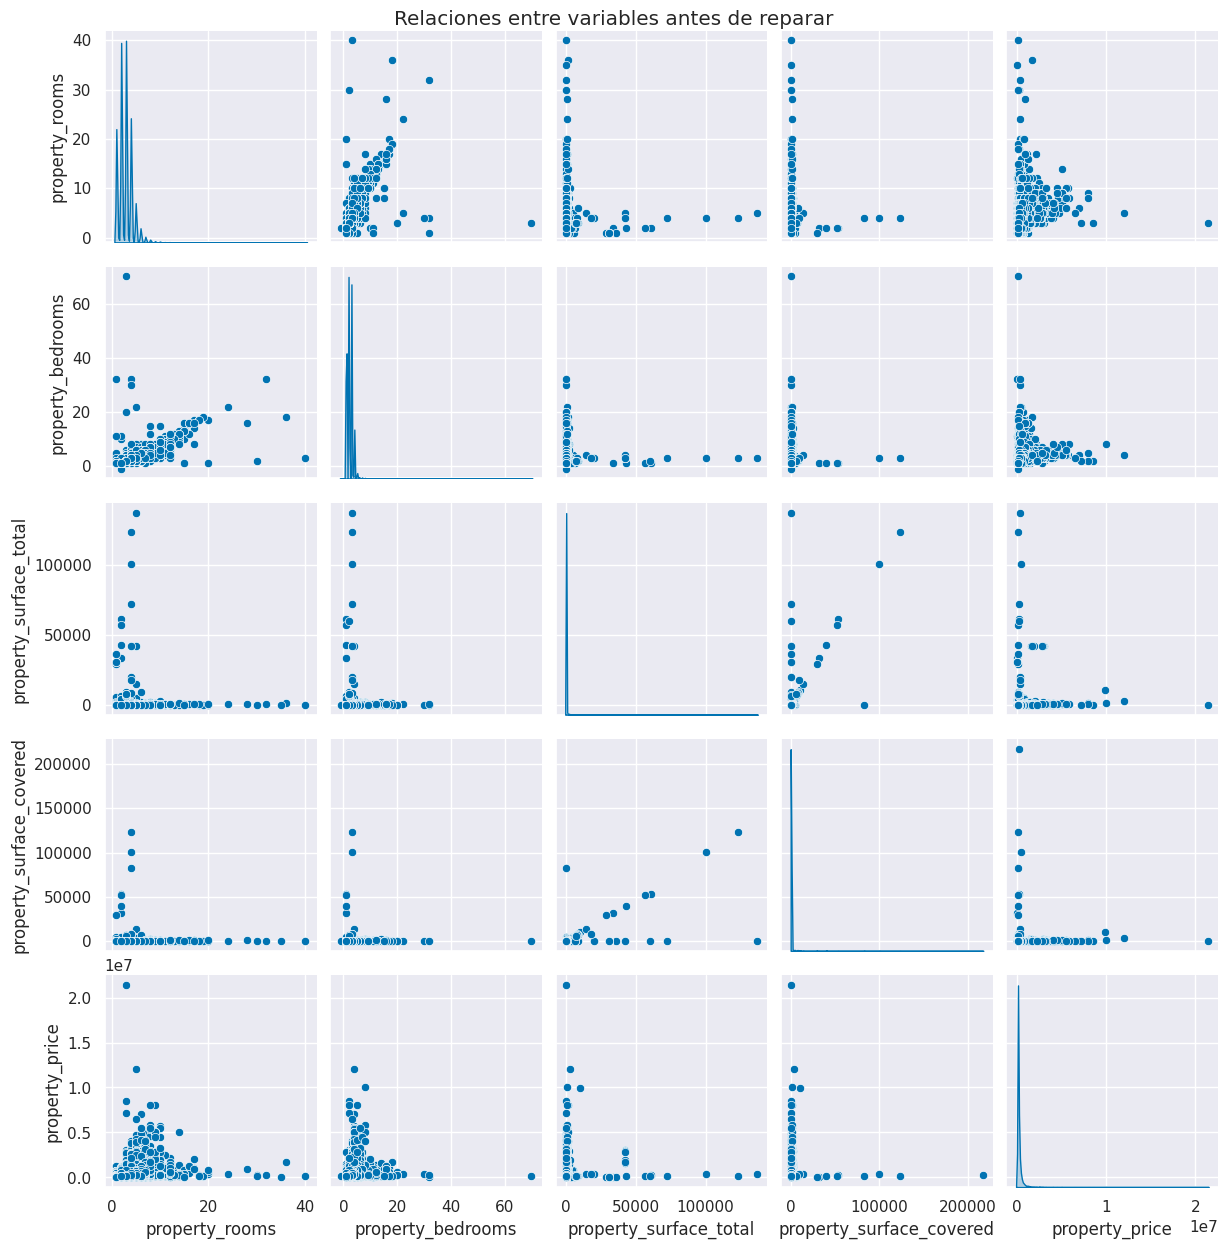

In [28]:
# Utilizamos un diagrama de distribución en vez de un histograma para reducir el tiempo de cómputo.
# Igualmente nos dan a entender la misma idea en este caso.
g = sns.pairplot(data=df.drop(["latitud", "longitud"], axis="columns"), diag_kind="kde")
g.fig.suptitle("Relaciones entre variables antes de reparar", y=1)

Llama la atención que varios de los gráficos de disperción entre variables son de "larga cola", lo que podría estar reafirmando la sospecha de la presencia de valores atípicos. Esto es especialmente evidente en los histogramas en la diagonal que grafican a cada variable consigo misma, donde pareciera haber un rango significativo de valores dispersos.

Analizamos la correlación entre variables utilizando el coeficiente de correlación de Pearson.

<Axes: title={'center': 'Correlación entre variables numéricas'}>

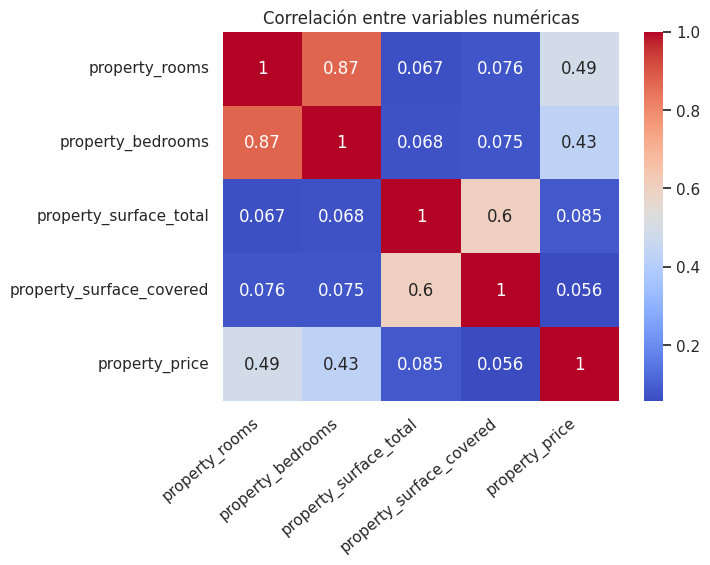

In [29]:
correlaciones = sns.heatmap(data=df.drop(["latitud", "longitud"], axis=1).select_dtypes("number").corr(), annot=True, cmap="coolwarm")
correlaciones.set(title="Correlación entre variables numéricas")
correlaciones.set_xticks(correlaciones.get_xticks()) # Evita un warning de Matplotlib con el siguiente comando.
correlaciones.set_xticklabels(correlaciones.get_xticklabels(), rotation=40, ha="right")

correlaciones

Lo más notorio en cuanto a correlaciones entre variables antes de hacer manejo de valores atípicos y datos nulos, es que relación entre las variables `property_rooms` y `property_bedrooms`. Es sensato pensar que las propiedades con más habitaciones tienen más cuartos y viceversa. Además, estas mismas dos variables son las que más se relacionan (linealmente) con el precio de la propiedad.

### Variable cualitativas

Las variables cualitativas con las que contamos son variables de texto y fecha. Son del tipo nominales, es decir, variables que pueden ser consideradas como opciones de categorías pero que no tienen un orden específico. Las columnas en cuestión son: `start_date`, `end_date`, `place_l3`, `place_l4` y `property_type`.

In [30]:
df.select_dtypes("object").drop("id", axis="columns")

start_date    end_date         neighbourhood sub_neighbourhood  \
25      2021-09-09  2021-09-26                   NaN               NaN   
42      2021-09-09  2021-09-26                  Boca               NaN   
43      2021-09-09  2021-09-28                  Boca               NaN   
49      2021-09-09  2022-01-05                  Once               NaN   
51      2021-09-09  2022-03-09                 Boedo               NaN   
...            ...         ...                   ...               ...   
460072  2021-01-05  2022-09-02      Villa del Parque               NaN   
460073  2021-01-05  2021-02-17      Villa del Parque               NaN   
460074  2021-01-05  2021-01-27      Villa del Parque               NaN   
460075  2021-01-05  2021-01-27      Villa del Parque               NaN   
460090  2021-01-05  2021-01-08  Centro / Microcentro               NaN   

       property_type                                     property_title  
25              Casa        VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
42      Departamento             VENTA TRES AMBIENTES LA BOCA PISO ALTO  
43      Departamento         Departamento - 4 Ambientes - Catalinas Sur  
49      Departamento                Venta departamento 4 ambientes Once  
51                PH                                         PH - Boedo  
...              ...                                                ...  
460072  Departamento      Espectacular 4 amb130m2 con Balcon Terraza!!!  
460073  Departamento        3 ambientes con cochera listo para habitar!  
460074  Departamento  VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...  
460075  Departamento  VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...  
460090  Departamento               VENTA DEPTO 2 1/2 AMBIENTES - CENTRO  

[94249 rows x 6 columns]

Examinando las variables del tipo fecha podemos observar que tenemos 365 fechas únicas. Todas son del año 2021, lo que significa que hubieron nuevas propiedades enlistadas para venta todos los días del año.

In [31]:
print(f"Cantidad fechas únicas: {len(df['start_date'].unique())}")

Cantidad fechas únicas: 365


In [32]:
pd.to_datetime(df["start_date"]).apply(lambda x: x.year).unique()

array([2021])

Sin embargo, con los valores de la variable `end_date` hay un rango de fechas mucho más amplio, en el que incluso llegamos a encontrar fechas del año 9999.

In [33]:
df[df["end_date"].str.contains("9999")]["end_date"]

1233      9999-12-31
1471      9999-12-31
1495      9999-12-31
1520      9999-12-31
1932      9999-12-31
             ...    
460015    9999-12-31
460019    9999-12-31
460020    9999-12-31
460028    9999-12-31
460065    9999-12-31
Name: end_date, Length: 5041, dtype: object

Interpretamos estos valores como registros que todavía seguían listados al momento de generar el dataset, es decir, propiedades que todavía no se habían vendido. La gran cantidad de casos en los que pasa esto descarta posibles errores en el ingreso de esos datos.

En cuanto los valores de la variable `barrio`, podemos observar los valores posibles y sus frecuencias:

In [34]:
df["neighbourhood"].value_counts()

neighbourhood
Palermo                 14308
Belgrano                 8898
Caballito                7168
Recoleta                 6282
Villa Urquiza            4673
Almagro                  4081
Nuñez                    3546
Villa Crespo             3189
Flores                   3110
Barrio Norte             2975
Balvanera                2553
Colegiales               1951
Villa Devoto             1921
Villa del Parque         1829
Saavedra                 1829
Puerto Madero            1493
San Telmo                1380
San Cristobal            1300
San Nicolás              1295
Retiro                   1250
Barracas                 1246
Boedo                    1237
Floresta                 1195
Monserrat                1115
Parque Chacabuco         1073
Villa Pueyrredón         1011
Coghlan                   984
Villa Luro                727
Mataderos                 719
Chacarita                 697
Liniers                   668
Villa Ortuzar             662
Parque Patricios          

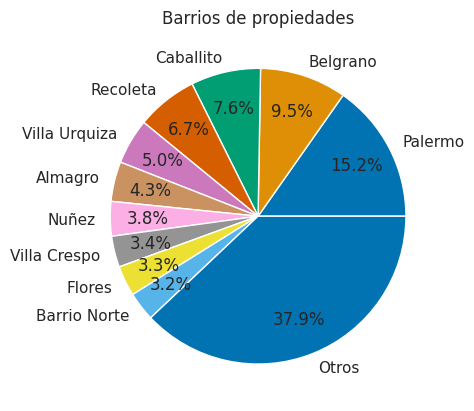

In [35]:
def distribucion_barrios(df, n_barrios, title=''):
  frecuencias_barrios = df["neighbourhood"].value_counts().sort_values(ascending=False)

  barrios_mas_comunes = frecuencias_barrios.iloc[:n_barrios]
  barrios_mas_comunes["Otros"] = frecuencias_barrios.iloc[n_barrios:].sum()

  plt.pie(barrios_mas_comunes, labels=barrios_mas_comunes.index,
          autopct="%1.1f%%", pctdistance=0.75)
  plt.title(label=title)

distribucion_barrios(df, 10, "Barrios de propiedades")

En cuanto a los sub-barrios podemos ver que solamente aquellas propiedades que se encuentran en Palermo tienen información sobre el subbarrio en el que se encuentran.

In [36]:
sub_barrios = df[df["sub_neighbourhood"].notnull()]["sub_neighbourhood"].value_counts()
sub_barrios

sub_neighbourhood
Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: count, dtype: int64

In [37]:
porcentaje_con_sub_barrios = sub_barrios.sum() / len(df) * 100

print(f"Porcentaje propiedades con sub-barrio: {round(porcentaje_con_sub_barrios, 2)}%")

Porcentaje propiedades con sub-barrio: 3.87%


Finalmente, si analizamos el campo `property_type` que filtramos anteriormente para solo tener propiedades de los tipos 'Casa', 'PH' o 'Departamento' tiene las siguientes métricas:

In [38]:
df["property_type"].value_counts()

property_type
Departamento    80829
PH               9266
Casa             4154
Name: count, dtype: int64

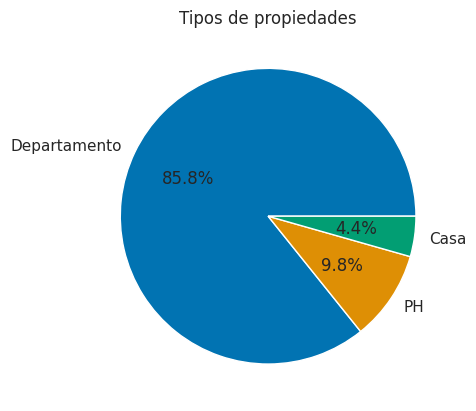

In [39]:
def distribucion_property_type(df, title=''):
  property_types = df["property_type"].value_counts()

  plt.pie(property_types, labels=property_types.index,
          autopct="%1.1f%%")
  plt.title(label=title)

distribucion_property_type(df, "Tipos de propiedades")

## Limpieza de datos

Guardamos una copia del dataset antes de lidiar con los datos nulos y outliers para posteriormente comparar la distribución y estadísticas del mismo con la versión resultante de los procesos de limpieza.

In [40]:
df_pre_limpieza = df.copy()

In [41]:
len(df)

94249

Observamos los porcentajes de datos nulos por columna:

In [42]:
porcentajes_nulos = df.isna().sum() / len(df) * 100
porcentajes_nulos = porcentajes_nulos[porcentajes_nulos > 0]
porcentajes_nulos

latitud                      3.957602
longitud                     3.957602
neighbourhood                0.442445
sub_neighbourhood           96.134707
property_rooms               1.107704
property_bedrooms           11.657418
property_surface_total       5.139577
property_surface_covered     3.558658
dtype: float64

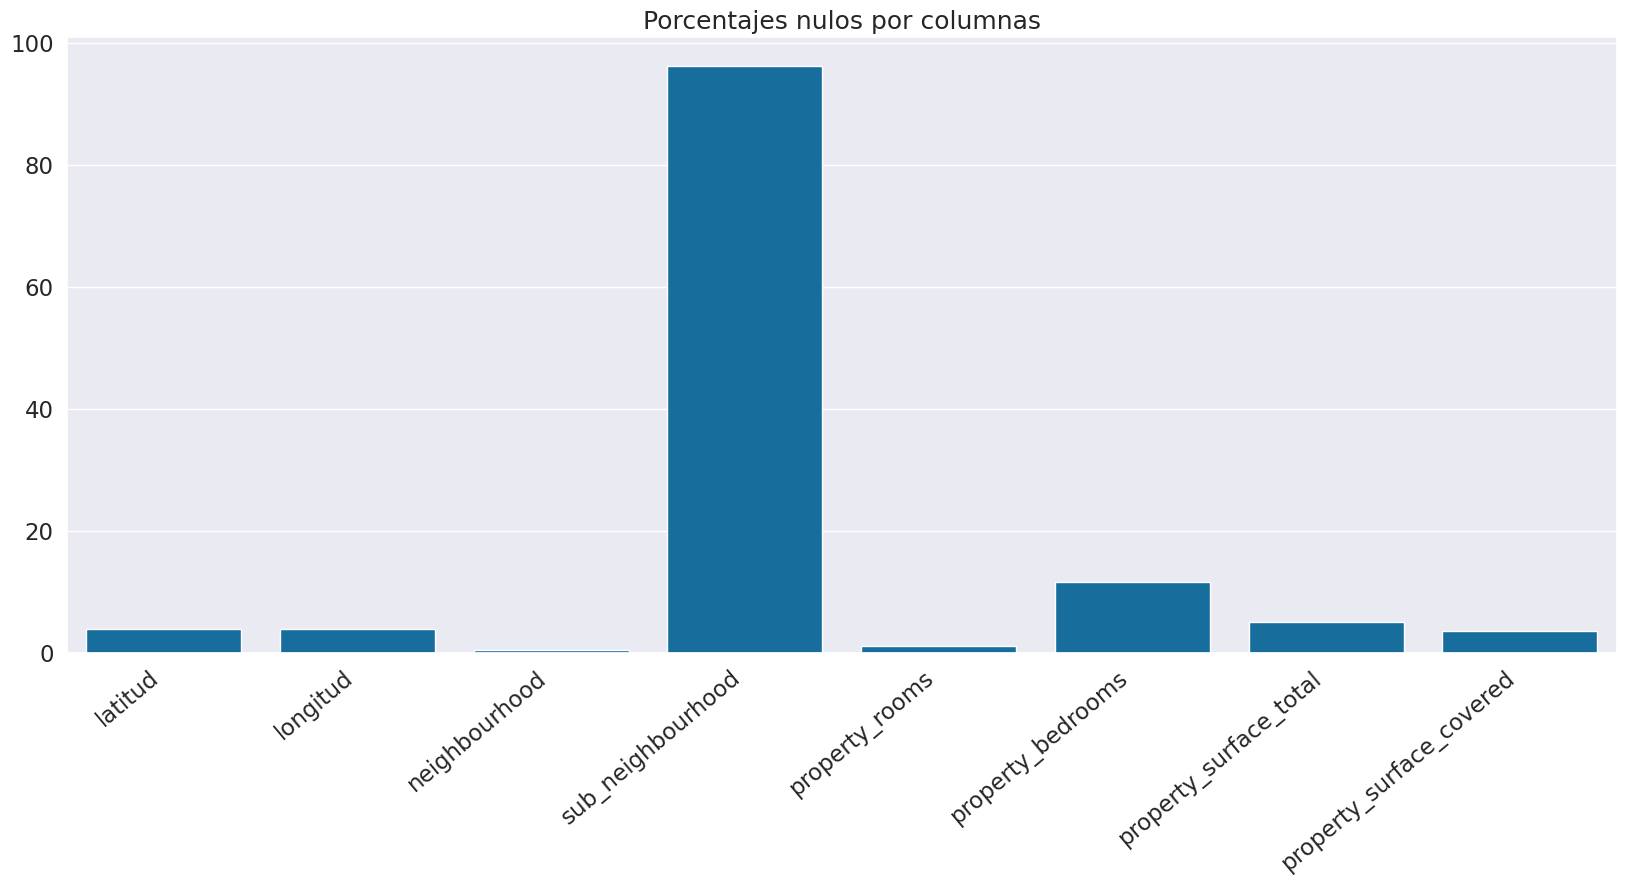

In [43]:
plt.figure(figsize=(20,8))
with sns.plotting_context("notebook", font_scale=1.5):
  porcentajes_nulos_grafico = sns.barplot(porcentajes_nulos)
  porcentajes_nulos_grafico.set(title="Porcentajes nulos por columnas")
  porcentajes_nulos_grafico.set_xticks(porcentajes_nulos_grafico.get_xticks()) # Evita un warning de Matplotlib con el siguiente comando.
  porcentajes_nulos_grafico.set_xticklabels(porcentajes_nulos_grafico.get_xticklabels(), rotation=40, ha="right")

Podríamos analizar lo mismo pero a nivel de fila, es decir, determinar cuántas filas tienen solo 1 columna nula, cuántas tiene 2, cuántas tiene todas las columnas nulas, etc.

In [44]:
porcentajes_nulos_por_fila = df.isna().sum(axis="columns").value_counts() / len(df) * 100
porcentajes_nulos_por_fila

1    75.502127
2    16.618744
3     4.359728
0     2.568728
4     0.727859
5     0.112468
6     0.109285
7     0.001061
Name: count, dtype: float64

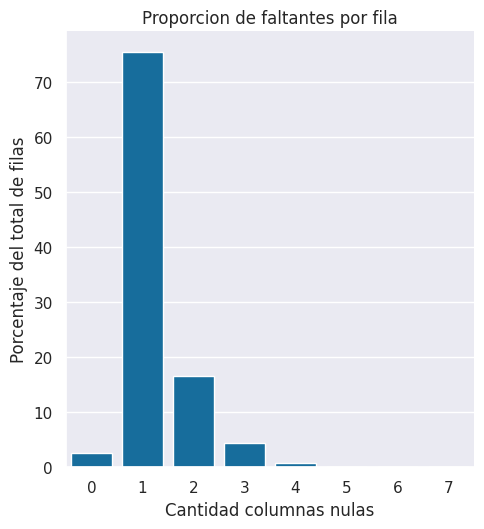

In [45]:
fig = sns.catplot(data=porcentajes_nulos_por_fila, kind="bar").set(xlabel="Cantidad columnas nulas",
                                                            ylabel="Porcentaje del total de filas")
fig.set(title="Proporcion de faltantes por fila")
plt.show()

Es decir, que la mayoría de los registros que contienen columnas nulas tiene solamente 1 columna nula.

#### Barrios

Sabemos de los análisis anteriores que un alto porcentaje de propiedades tienen solamente 1 columna con datos nulos, y que a la vez, muchos registros tienen la columna `sub_neighbourhood` también sin datos, por lo que podríamos ver si este alto porcentaje de registros con solo 1 columna nula se debe a sus valores para este último campo.

In [46]:
cantidad_con_1_col_nula = df.isna().sum(axis="columns").value_counts()[1]
cantidad_solo_sub_neighbourhood_nulo = len(df[
    (df.isna().sum(axis="columns") == 1) &
    (df["sub_neighbourhood"].isna())
])

print(f"Porcentaje con solo `sub_neighbourhood` nulo: {round(cantidad_solo_sub_neighbourhood_nulo / cantidad_con_1_col_nula * 100, 2)}%")

Porcentaje con solo `sub_neighbourhood` nulo: 98.99%


Efectivamente, casi el 99% de los registros a los que les falta solo una feature (conjunto que a su vez representa al casi 75% de los registros con nulos totales) son propiedades que no tienen información sobre el sub-barrio en el que se encuentran. Debido a esto, decidimos eliminar esta columna también.

In [47]:
df = df.drop("sub_neighbourhood", axis="columns")

Por otra parte, el poncentaje de propiedades que no tienen información de su barrio es bajo. Sabiendo que tenemos información sobre la latitud y longitud de las mismas, podríamos completar la información del barrio que falta en una propiedad si contamos con sus coordenadas. Para esto vamos a utilizar la información provista por el Gobierno de la Ciudad mediante [este dataset](https://data.buenosaires.gob.ar/dataset/barrios) y aplicar la técnica Cold-Deck.

In [48]:
barrios = pd.read_csv("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.csv", delimiter=";")[["BARRIO", "WKT"]]
barrios["WKT"] = barrios["WKT"].apply(wkt.loads)

barrios = gpd.GeoDataFrame(barrios, geometry="WKT").rename({"BARRIO": "neighbourhood"}, axis="columns")

Tenemos que cambiar los nombres de los barrios en el dataset del gobierno para que coincidan con los nombres de los barrios que ya tenemos, para que no se introduzcan nuevas variantes para esta categoría cuando se está intentando representar el mismo barrio.

In [49]:
barrios["neighbourhood"] = barrios["neighbourhood"].apply(lambda x: x.title())

barrios_gcba = set(barrios["neighbourhood"].unique())
barrios_properati = set(df[df["neighbourhood"].notnull()]["neighbourhood"].unique())

display(barrios_properati.difference(barrios_gcba)) # Están en el ds de Properati pero no en el de GCBA
display(barrios_gcba.difference(barrios_properati)) # Están en el ds de GCBA pero no en el de Properati

{'Abasto',
 'Agronomía',
 'Barrio Norte',
 'Catalinas',
 'Centro / Microcentro',
 'Congreso',
 'Constitución',
 'Las Cañitas',
 'Once',
 'Parque Centenario',
 'Pompeya',
 'San Nicolás',
 'Tribunales',
 'Villa General Mitre',
 'Villa Pueyrredón',
 'Villa del Parque'}

{'Agronomia',
 'Constitucion',
 'Nueva Pompeya',
 'San Nicolas',
 'Villa Del Parque',
 'Villa Gral. Mitre',
 'Villa Pueyrredon'}

In [50]:
barrios["neighbourhood"] = barrios["neighbourhood"].replace({
  "Agronomia": "Agronomía",
  "Constitucion": "Constitución",
  "San Nicolas": "San Nicolás",
  "Villa Del Parque": "Villa del Parque",
  "Villa Gral. Mitre": "Villa General Mitre",
  "Villa Pueyrredon": "Villa Pueyrredón"
})

In [51]:
from shapely.geometry import Point

def asignar_barrio(propiedad):
  latitud, longitud = propiedad["latitud"], propiedad["longitud"]
  barrios.contains(Point(longitud, latitud))
  try:
    propiedad["neighbourhood"] = barrios[barrios.contains(Point(longitud, latitud))]["neighbourhood"].iloc[0]
  except IndexError:
    pass

  return propiedad

In [52]:
df = df.apply(lambda p: p if not pd.isna(p["neighbourhood"]) else asignar_barrio(p), axis="columns")

Luego de aplicar la técnica de Cold-Deck, vemos que aún nos queda ciertas filas con barrios nulos. Con lo cual, procedemos a ver cuantas de esas filas tampoco tienen coordenadas válidas.

In [53]:
df['neighbourhood'].isna().value_counts()

neighbourhood
False    93883
True       366
Name: count, dtype: int64

In [54]:
len(df[df['neighbourhood'].isna() & ((df['latitud'].isna()) | (df['longitud'].isna()))])

170

De las 366 filas que no tienen barrio, 170 tampoco tienen longitud o latitud, por lo que decidimos dropearlas.

In [55]:
porcentajes_nulos_neighbourhood = df['neighbourhood'].isna().sum() / len(df) * 100
porcentajes_nulos_neighbourhood

0.3883330327112224

In [56]:
df = df.dropna(subset=['neighbourhood'])

Sin embargo, todavía nos quedan algunas propiedades que tienen información del barrio, pero no tienen información de su latitud ni longitud. Lo que vamos a hacer para estas propiedades es ubicarlas en el centro de sus respectivos barrios.

In [57]:
cantidad_sin_coords = len(df[(df['latitud'].isna() | df['longitud'].isna())])
print("Cantidad con barrios sin coordenadas antes de Cold-Deck:", cantidad_sin_coords)

Cantidad con barrios sin coordenadas antes de Cold-Deck: 3560


In [58]:
barrios_con_centro = barrios.copy()
barrios_con_centro["centro"] = barrios.centroid

def asignar_coordenadas(propiedad):
  barrio = propiedad["neighbourhood"]

  try:
    centro = barrios_con_centro[barrios_con_centro["neighbourhood"] == barrio]["centro"]
    propiedad["latitud"], propiedad["longitud"] = centro.get_coordinates().values[0]
  except IndexError:
    pass

  return propiedad

In [59]:
df = df.apply(lambda p: asignar_coordenadas(p) if pd.isna(p["latitud"]) or pd.isna(p["longitud"]) else p, axis="columns")

Sin bien no se logró encontrar el centro de coordenadas de todos los barrios de las propiedades de Properati, se redujo la cantidad de registros con latitud y longitud nulos de 3560 a 309, lo cual es una reducción significativa.

In [60]:
cantidad_sin_coords = len(df[(df['latitud'].isna() | df['longitud'].isna())])
print("Cantidad con barrios sin coordenadas después de Cold-Deck:", cantidad_sin_coords)

Cantidad con barrios sin coordenadas después de Cold-Deck: 309


Si observamos algunos de los nombres de los barrios de las propiedades a las que no se les pudo asignar coordenadas, podemos observar que son nombres de subbarrios en vez de nombres oficiales de barrios reconocidos por el Gobierno de la Ciudad. Podríamos haber asignado a estos subbarrios las coordenadas de sus verdaderos barrios o haberles cambiado el nombre para unificarlos con los mismo, pero debido a que el número de propiedades es muy bajo en comparación con las propiedades a las que sí se les asignó un centro de coordenadas, decidimos mejor dropear estas faltantes.

In [61]:
df[(df["latitud"].isna()) | (df["longitud"].isna())]["neighbourhood"].value_counts()

neighbourhood
Barrio Norte            185
Congreso                 39
Once                     36
Tribunales               32
Abasto                   12
Pompeya                   3
Parque Centenario         1
Centro / Microcentro      1
Name: count, dtype: int64

In [62]:
df = df.dropna(subset=["longitud", "latitud"])

#### Áreas

Examinamos que sucede con las propiedades que no tienen `property_surface_total` ni `property_surface_covered`. Los porcentajes de registros que tienen nulo alguna de estas dos columnas son 5.09% y 3.56% respectivamente.

In [63]:
porcentaje_surface_total_na = round(len(df[df['property_surface_total'].isna()]) / len(df) * 100, 2)
porcentaje_surface_surface_na = round(len(df[df['property_surface_covered'].isna()]) / len(df) * 100, 2)

porcentaje_surface_total_na, porcentaje_surface_surface_na

(5.09, 3.56)

Optamos por utilizar la técnica MICE para completar los valores faltantes de estas dos columnas.

Outliers de `surface_total` y `surface_covered` antes de imputar.

In [64]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_surfaces = IterativeImputer(random_state=0)
df_impt_default = df.copy()
df_impt_default.loc[:, ["property_surface_total", "property_surface_covered"]] = impute_surfaces.fit_transform(df_impt_default[["property_surface_total", "property_surface_covered"]])

Viendo los outliers que tenemos ahora

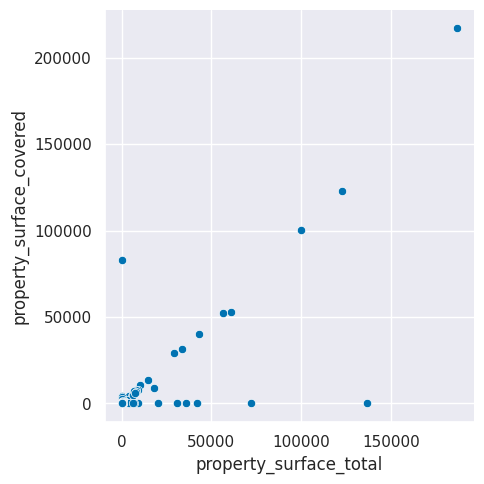

In [65]:
sns.relplot(data=df_impt_default, x="property_surface_total", y="property_surface_covered", kind="scatter")

Probamos cambiando la cantidad de iteraciones

In [66]:
impute_surfaces = IterativeImputer(random_state=0, max_iter=20, initial_strategy='most_frequent')
df_impt_median_20iter = df.copy()
df_impt_median_20iter.loc[:, ["property_surface_total", "property_surface_covered"]] = impute_surfaces.fit_transform(df_impt_median_20iter[["property_surface_total", "property_surface_covered"]])

Tras la imputación, vemos como nos quedan los outliers de ambas variables.

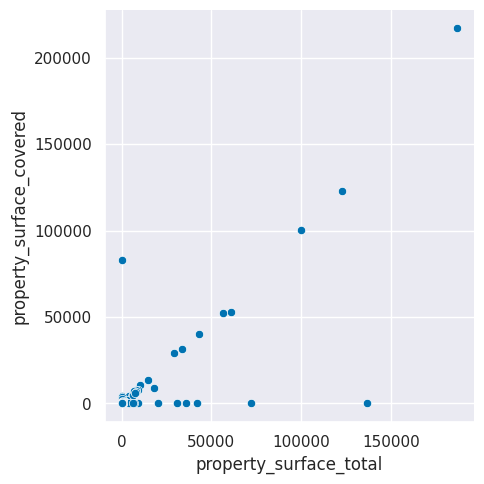

In [67]:
sns.relplot(data=df_impt_median_20iter, x="property_surface_total", y="property_surface_covered", kind="scatter")

Visualmente notamos que no hay muchas diferencias entre ambos métodos de imputación, por lo que otpamos por quedarnos con los valores del algoritmo MICE por defecto.

In [68]:
df = df_impt_default

Observamos la presencia de outliers para ambas variables tanto de manera independiente como conjunta. A partir del gráfico, decimos examinar individualmente aquellos cuya área superara los 25000 metros cuadrados.

In [69]:
df[(df["property_surface_covered"] > 25000) & (df["property_surface_total"] > 25000)]

id  start_date    end_date    latitud  \
1932    eQ/SiyES/mXWsSyAzb3k3A==  2021-12-17  9999-12-31 -34.637026   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 -34.578917   
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 -34.600113   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 -34.587320   
117835  vyRPw0ch6cIj9Ki5yPUneA==  2021-08-18  2021-08-23 -34.550093   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 -34.550093   
372779  XzTb7kTEpmAKiyhEGSWz4A==  2021-08-24  2021-09-03 -34.555278   
405324  tHz32dZ72wYshPnoABftrg==  2021-01-07  2021-06-02 -34.569963   

         longitud     neighbourhood property_type  property_rooms  \
1932   -58.426283  Parque Chacabuco          Casa             NaN   
72316  -58.429373           Palermo  Departamento             2.0   
72521  -58.403649         Balvanera  Departamento             2.0   
106598 -58.401556      Barrio Norte  Departamento             2.0   
117835 -58.483034          Saavedra  Departamento             2.0   
352883 -58.483034          Saavedra  Departamento             1.0   
372779 -58.459786          Belgrano  Departamento             4.0   
405324 -58.481658     Villa Urquiza            PH             4.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
1932                  NaN           187129.433654                  217000.0   
72316                 1.0            61130.000000                   53030.0   
72521                 1.0            33800.000000                   31670.0   
106598                1.0            56740.000000                   52540.0   
117835                1.0            43086.000000                   40038.0   
352883                NaN            29064.000000                   29064.0   
372779                3.0           100068.000000                  100051.0   
405324                3.0           123000.000000                  123000.0   

        property_price                                     property_title  
1932          250000.0   EXCEPCIONAL CASA DOS FAMILIAS - Parque Chacabuco  
72316         225000.0  VENTA DEPARTAMENTO 2 AMBIENTES PALERMO C/AMENI...  
72521          66000.0                        VENTA 2 AMBIENTES CON RENTA  
106598        175000.0  EXCELENTE DEPARTAMENTO DE 2 AMBIENTES DE CATEG...  
117835        114000.0     Venta Departamento 2 amb a Estrenar, Saavedra.  
352883         87400.0             VENTA MONOAMBIENTE SAAVEDRA A ESTRENAR  
372779        420000.0    VENTA PISO 4 AMBIENTES BELGRANO COCHERA BALCON   
405324        165000.0      VENTA OPORTUNIDAD! PH. IMPECABLE, 4 AMBIENTES

La única variable que podría haber aportado información necesaria para corregir posibles errores de imputación de los datos de área es el título de la propiedad, ya que ambos datos de área son incorrectos. En el caso estos outliers conjuntos encontrados, ninguna de sus descripciones fue útil para esto, así que decidimos dropearlos.

In [70]:
df = df.drop(df[(df["property_surface_covered"] > 25000) & (df["property_surface_total"] > 25000)].index)

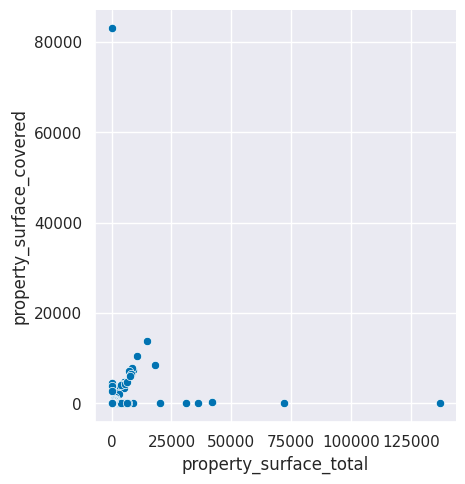

In [71]:
sns.relplot(data=df, x="property_surface_total", y="property_surface_covered", kind="scatter")

La subsecuente examinación gráfico de dispersión luego de la eliminación de estos outliers, desvía nuestra atención hacia los outliers propios de cada variable. Para esto, mejor utilizamos gráficos de caja para entender mejor cómo estos outliers se comparan con las métricas de los demás valores de sus respectivas variables.

[Text(0.5, 1.0, 'Boxplot de superficie cubierta')]

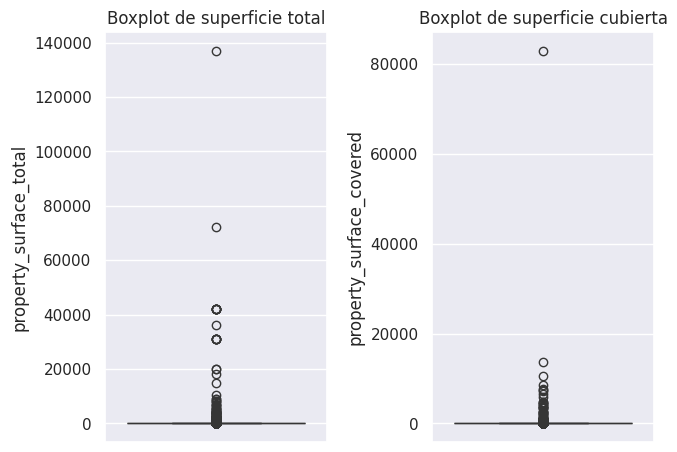

In [72]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout(w_pad=3)

sns.boxplot(y=df['property_surface_total'], ax=ax[0]).set(title="Boxplot de superficie total")
sns.boxplot(y=df['property_surface_covered'], ax=ax[1]).set(title="Boxplot de superficie cubierta")

Analizamos las estadísticas de estas variables para tener más información.

In [73]:
df[["property_surface_total", "property_surface_covered"]].describe()

property_surface_total  property_surface_covered
count            93566.000000              93566.000000
mean               103.014441                 80.524180
std                704.250124                294.739376
min                 10.000000                  1.000000
25%                 45.000000                 40.000000
50%                 67.000000                 58.000000
75%                105.000000                 88.000000
max             137000.000000              83000.000000

En base a los boxplots, podemos ver que hay un conjunto de propiedades que tiene sus valores de superficie particularmente altos, así que echamos un vistazo a las propiedades con `property_surface_total` y `property_surface_covered` más altos.

In [74]:
df[df["property_surface_total"] > 20000]

id  start_date    end_date    latitud  \
84073   vMD1fCSS0kedOs8Bk/PCjA==  2021-02-05  2021-05-16 -34.588175   
126869  MYZD6oNPlLhMzVLoEbL9jw==  2021-10-05  2021-11-04 -34.579163   
129214  tJ7TjXeyIl+4KPkaPqyAYA==  2021-07-01  9999-12-31 -34.599421   
219021  WQU6YIN+y4z30xaPRG4LHQ==  2021-03-07  2022-02-09 -34.636532   
237392  wGXDCrWhpDX+JQBrC+7jpA==  2021-02-27  2021-03-03 -34.628721   
275253  5nXtCXuxHhkZ51syuRB7YQ==  2021-09-15  2021-10-07 -34.579163   
300394  E2FhGbtCzmdLHk9QEY47BA==  2021-08-10  2021-09-15 -34.579163   
304492  Psg4w1RO9GxZAski6P2B8g==  2021-04-15  2021-06-05 -34.579163   
324541  s0do8ciUehI3xXZNULgg+Q==  2021-03-03  2021-03-23 -34.628721   
353009  f7xAHgUi1ruXPA9JxKGK6g==  2021-06-25  2021-08-10 -34.579163   
362741  G7sKDYpvhrBrps0xzAQrmQ==  2021-01-16  2021-04-14 -34.579163   
370917  OC6HYSBo/pqio5ZTLgoPvg==  2021-04-24  2021-06-05 -34.571747   
370918  rnFgWleVdid1Czn05PkodA==  2021-04-24  2021-06-05 -34.571747   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q==  2021-04-24  2021-06-05 -34.571747   
370920  HVcSoFtn8OjGl2rbv0GsBw==  2021-04-24  2021-06-05 -34.571747   
370921  DhCI1Vz1PAu5fOy930TFXw==  2021-04-24  2021-06-05 -34.571747   
370922  MkaLWAz6PgutYgXwXxPEjQ==  2021-04-24  2021-06-05 -34.571747   
370932  IQUQeru+sjv8TBWlLfs+SA==  2021-04-24  2021-06-05 -34.571747   

         longitud neighbourhood property_type  property_rooms  \
84073  -58.396261      Recoleta  Departamento             1.0   
126869 -58.455725    Colegiales  Departamento             1.0   
129214 -58.386867  Barrio Norte  Departamento             5.0   
219021 -58.376406      Barracas  Departamento             4.0   
237392 -58.421383         Boedo            PH             4.0   
275253 -58.455725    Colegiales  Departamento             1.0   
300394 -58.455725    Colegiales  Departamento             1.0   
304492 -58.455725    Colegiales  Departamento             1.0   
324541 -58.421383         Boedo            PH             4.0   
353009 -58.455725    Colegiales  Departamento             1.0   
362741 -58.455725    Colegiales  Departamento             1.0   
370917 -58.422612       Palermo  Departamento             4.0   
370918 -58.422612       Palermo  Departamento             4.0   
370919 -58.422612       Palermo  Departamento             5.0   
370920 -58.422612       Palermo  Departamento             5.0   
370921 -58.422612       Palermo  Departamento             5.0   
370922 -58.422612       Palermo  Departamento             5.0   
370932 -58.422612       Palermo  Departamento             4.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
84073                 NaN                 36000.0                      30.0   
126869                NaN                 31000.0                      26.0   
129214                3.0                137000.0                     135.0   
219021                3.0                 72060.0                      90.0   
237392                3.0                 20041.0                     139.0   
275253                NaN                 31000.0                      26.0   
300394                NaN                 31000.0                      26.0   
304492                NaN                 31000.0                      26.0   
324541                3.0                 20041.0                     139.0   
353009                NaN                 31000.0                      26.0   
362741                NaN                 31000.0                      26.0   
370917                3.0                 42110.0                     222.0   
370918                3.0                 42110.0                     307.0   
370919                4.0                 42110.0                     307.0   
370920                4.0                 42110.0                     307.0   
370921                4.0                 42110.0                     307.0   
370922                4.0                 42110.0                     307.0   
370932                

Entre estos registros destacamos el que tiene valor de área total de 137000 metros cuadrados, que podría deberse a un error en momento de cargar el registro de la propiedad, ya que los tres primeros dígitos de este número se asemejan a los dígitos del valor de `property_surface_covered`. Si efectivamente nos fijamos en la descripción de la propiedad, ahí mismo se menciona que el área de la propiedad es 137 metros cuadrados, por lo tanto, corregimos el registro.

In [75]:
df.loc[129214, "property_surface_total"] = 137

Y también en la propiedad de Recoleta con 36000 metros totales y solamente 30 cubiertos. Además, sabemos que esta propiedad es un monoambiente por su descripción, por lo que que tenga entre 30 y 40 metros de área tiene sentido, así que corregimos este registro también.

In [76]:
df.loc[84073, "property_surface_total"] = 36

También observamos un grupo de propiedades que por su descripción parecieran ser todas del mismo edificio (Av. Alvarez Thomas 970 - Colegiales). Todas tienen el mismo valor tanto en el campo `property_surface_total` y `property_surface_covered`, y el valor de esta primera variable pareciera sufrir de un error similar a los anteriores, donde los primeros dígitos del `property_surface_total` (que vale 31000) se asemejan a los primeros dígitos de la segunda variable (26). Por lo tanto, corregimos estos ingresos.

Observando otras propiedades en este mismo edificio, vemos que hay bastantes que efectivamente tienen 31 metros cuadrados de área.

In [77]:
esta_en_edificio_alvarez_thomas = df["property_title"].str.contains("Av. Alvarez Thomas 970 - Colegiales - Capital")
df[(esta_en_edificio_alvarez_thomas) & (df["property_surface_total"] == 31)].head()[["property_surface_total",	"property_surface_covered",	"property_title"]]

property_surface_total  property_surface_covered  \
79363                     31.0                      26.0   
79366                     31.0                      26.0   
126871                    31.0                      26.0   
215581                    31.0                      26.0   
215586                    31.0                      26.0   

                                           property_title  
79363   Av. Alvarez Thomas 970 - Colegiales - Capital ...  
79366   Av. Alvarez Thomas 970 - Colegiales - Capital ...  
126871  Av. Alvarez Thomas 970 - Colegiales - Capital ...  
215581  Av. Alvarez Thomas 970 - Colegiales - Capital ...  
215586  Av. Alvarez Thomas 970 - Colegiales - Capital ...

In [78]:
df.loc[(esta_en_edificio_alvarez_thomas) & (df["property_surface_total"] == 31000), "property_surface_total"] = 31

Podría estar pasando lo mismo con los departamentos cuya descripción contienen 'Reventa - Departamento - Palermo Nuevo'. El valor real de este campo para todos estos registros podría ser de 421.

In [79]:
esta_en_edificio_palermo_nuevo = df["property_title"].str.contains("Reventa - Departamento - Palermo Nuevo")
df[esta_en_edificio_palermo_nuevo]

id  start_date    end_date    latitud  \
370917  OC6HYSBo/pqio5ZTLgoPvg==  2021-04-24  2021-06-05 -34.571747   
370918  rnFgWleVdid1Czn05PkodA==  2021-04-24  2021-06-05 -34.571747   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q==  2021-04-24  2021-06-05 -34.571747   
370920  HVcSoFtn8OjGl2rbv0GsBw==  2021-04-24  2021-06-05 -34.571747   
370921  DhCI1Vz1PAu5fOy930TFXw==  2021-04-24  2021-06-05 -34.571747   
370922  MkaLWAz6PgutYgXwXxPEjQ==  2021-04-24  2021-06-05 -34.571747   

         longitud neighbourhood property_type  property_rooms  \
370917 -58.422612       Palermo  Departamento             4.0   
370918 -58.422612       Palermo  Departamento             4.0   
370919 -58.422612       Palermo  Departamento             5.0   
370920 -58.422612       Palermo  Departamento             5.0   
370921 -58.422612       Palermo  Departamento             5.0   
370922 -58.422612       Palermo  Departamento             5.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
370917                3.0                 42110.0                     222.0   
370918                3.0                 42110.0                     307.0   
370919                4.0                 42110.0                     307.0   
370920                4.0                 42110.0                     307.0   
370921                4.0                 42110.0                     307.0   
370922                4.0                 42110.0                     307.0   

        property_price                                     property_title  
370917       1910920.0  Reventa - Departamento - Palermo Nuevo - Liber...  
370918       1568760.0  Reventa - Departamento - Palermo Nuevo - Liber...  
370919       3044250.0  Reventa - Departamento - Palermo Nuevo - Liber...  
370920       2890500.0  Reventa - Departamento - Palermo Nuevo - Liber...  
370921       2890500.0  Reventa - Departamento - Palermo Nuevo - Liber...  
370922       2829000.0  Reventa - Departamento - Palermo Nuevo - Liber...

In [80]:
df.loc[esta_en_edificio_palermo_nuevo, "property_surface_total"] = 421

Dropeamos el resto de observaciones en este extremo.

In [81]:
df = df.drop(df[df["property_surface_total"] > 20000].index)

Del mismo modo, desviamos nuestra atención al outliers más lejano de `property_surface_covered`.

In [82]:
df[df["property_surface_covered"] == df["property_surface_covered"].max()]

id  start_date    end_date    latitud  \
199905  EDZUWORq83zRgdk9Zqlv+A==  2021-07-25  9999-12-31 -34.604362   

         longitud neighbourhood property_type  property_rooms  \
199905 -58.392366  Barrio Norte  Departamento             4.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
199905                NaN                    83.0                   83000.0   

        property_price                       property_title  
199905        155000.0  AMPLIO DEPTO  EN VENTA BARRIO NORTE

El dato de su superficie cubierta total, y la similitud de sus primeros dígitos con el valor ingreso de superficie cubierta, nos hacen pensar que también se trata de un error de tipeo, por lo que corregimos el dato.

In [83]:
df.loc[199905, "property_surface_covered"] = 83

Los demás outliers de esta variable se encuentran razonablemente más cercanos al resto del conjunto de valores de esta variable, por lo que no los examinamos de manera individual.

Finalmente, podemos ver como quedan los boxplots de ambas variables luego del procesamiento realizado.

[Text(0.5, 1.0, 'Boxplot de superficie cubierta')]

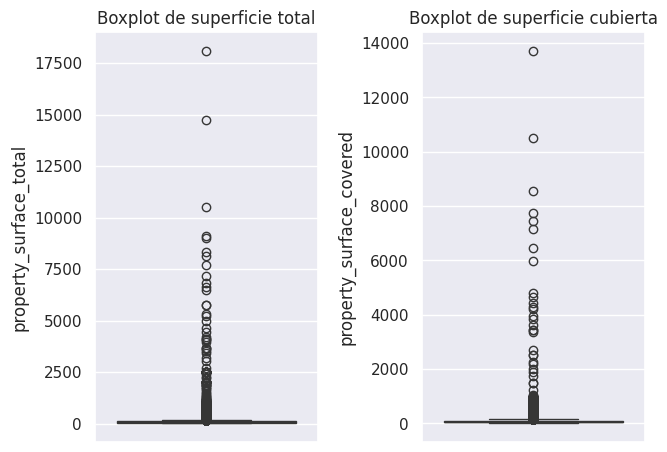

In [84]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout(w_pad=3)

sns.boxplot(y=df['property_surface_total'], ax=ax[0]).set(title="Boxplot de superficie total")
sns.boxplot(y=df['property_surface_covered'], ax=ax[1]).set(title="Boxplot de superficie cubierta")

Si volvemos a observar las estadísticas, seguimos encontrando posibles outliers en el extremo inferior de las medidas de área, por ejemplo, una propiedad de solamente 10 metros cuadrados y una que solamente tiene 1 metro cuadrado cubierto.

In [85]:
df[["property_surface_total", "property_surface_covered"]].describe()

property_surface_total  property_surface_covered
count            93562.000000              93562.000000
mean                94.863536                 79.634183
std                157.388507                115.694826
min                 10.000000                  1.000000
25%                 45.000000                 40.000000
50%                 67.000000                 58.000000
75%                105.000000                 88.000000
max              18096.000000              13717.000000

In [86]:
df[df["property_surface_total"] == 10][["property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_title"]]

property_rooms  property_bedrooms  property_surface_total  \
21153              3.0                NaN                    10.0   
32068              3.0                2.0                    10.0   
38433              1.0                1.0                    10.0   
180380             3.0                NaN                    10.0   
334734             2.0                1.0                    10.0   

        property_surface_covered  \
21153                  21.912859   
32068                  65.000000   
38433                  10.000000   
180380                 21.912859   
334734                 60.000000   

                                           property_title  
21153                                  Departamento venta  
32068   A mts de Cabildo y F Lacroze  - 2 Edificios co...  
38433               Viamonte 1600 - Venta Ideal Inversión  
180380                                 Departamento venta  
334734  Departamento - 2 Ambientes - Venta - Villa Urq...

Observamos que algunos de estas propiedades que tienen más superficie cubierta que superficie total. Esto sería un error lógico, por lo que consideramos todas las propiedades que tienen esta condición como outliers. Investigamos qué otras propiedades tienen esta condición.

In [87]:
mas_surface_covered_que_total = df[df["property_surface_covered"] > df["property_surface_total"]]
len(mas_surface_covered_que_total)

1301

Valoramos volver a imputar el valor de la variable `property_surface_covered` con el de `property_surface_total`, para que las propiedades que tienen esta condición, tuvieran igual valor en ambas variables, pero finalmente decidimos dropearlas todas, ya que de hacer esto, estaríamos asumiendo esta igualdad sin fundamento, ya que las demás variables no nos dan información al respecto.

In [88]:
df = df.drop(mas_surface_covered_que_total.index)

Ahora analizamos las que tienen solamente 1 metro cuadrado cubierto.

In [89]:
df[df["property_surface_covered"] == 1][["property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_title"]]

property_rooms  property_bedrooms  property_surface_total  \
6980               NaN                3.0               35.266409   
7869               2.0                1.0               35.266409   
7881               3.0                2.0               35.266409   
10472              4.0                3.0               35.266409   
17494              NaN                NaN               35.266409   
41408              3.0                2.0               35.266409   
41540              3.0                2.0               35.266409   
41742              4.0                3.0               35.266409   
41746              3.0                2.0               35.266409   
41866              1.0                NaN               35.266409   
41903              1.0                NaN               35.266409   
41935              4.0                3.0               35.266409   
41944              3.0                2.0               35.266409   
41975              1.0                NaN               35.266409   
41980              5.0                4.0               35.266409   
41987              3.0                2.0               35.266409   
41995              5.0                4.0               35.266409   
42004              5.0                4.0               35.266409   
42078              3.0                2.0               35.266409   
42084              1.0                NaN               35.266409   
55729              4.0                3.0              117.000000   
193691             3.0                2.0               80.000000   
227332             2.0                1.0               35.266409   
326305             1.0                1.0               35.266409   
405728             4.0                3.0               35.266409   
405778             4.0                3.0              117.000000   
412097             3.0                2.0               50.000000   
438089             3.0                2.0               35.266409   
458875             NaN                2.0               35.266409   

        property_surface_covered  \
6980                         1.0   
7869                         1.0   
7881                         1.0   
10472                        1.0   
17494                        1.0   
41408                        1.0   
41540                        1.0   
41742                        1.0   
41746                        1.0   
41866                        1.0   
41903                        1.0   
41935                        1.0   
41944                        1.0   
41975                        1.0   
41980                        1.0   
41987                        1.0   
41995                        1.0   
42004                        1.0   
42078                        1.0   
42084                        1.0   
55729                        1.0   
193691                       1.0   
227332                       1.0   
326305                       1.0   
405728                       1.0   
405778                       1.0   
412097                       1.0   
438089                       1.0   
458875                       1.0   

                                           property_title  
6980     CASA EN VENTA EN VILLA LUGANO PARA DOS FAMILIAS   
7869            DEPARTAMENTO EN VENTA BARRIO PIEDRABUENA   
7881          VENTA HERMOSO DEPARTAMENTO EN BARRIO SAMORE  
10472           EXCELENTE PH 4 AMBIENTES IDEAL 2 FAMILIAS  
17494   Soler 5880 Palermo/// Pago 50% Contado , Saldo...  
41408   3 Ambientes a estrenar c/ cochera y parrilla e...  
41540   3 Ambientes a estrenar c/ cochera y parrilla e...  
41742              PH 4 AMBIENTES C/TERRAZA A REFACCIONAR  
41746   3 Ambientes a estrenar c/ cochera y parrilla e...  
41866                   Monoambiente al frente con balcón  
41903   Departamento 1 Ambiente al frente con Balcón D...  
41935                       Ph en 2 plantas a refaccionar  
41944              Hermoso Ph de 3 ambientes con 2 patios  
41975   Departam

No poemos rescatar nada de esta información asi que decidimos dropear estos registros.

In [90]:
df = df.drop(df[df["property_surface_covered"] == 1].index)

Hacemos un análisis similar para las demás propiedades que tienen un valor inusualmente bajo de área cubierta, por ejemplo, propiedades con menos de 20 metros cuadrados cubiertos, que, a menos que la propiedad fuese un medioambiente, consideramos que sería un valor muy bajo para una propiedad.

Como son pocos valores, decidimos dropearlos.

In [91]:
len(df[(df["property_surface_covered"] < 20) & ~(df["property_rooms"] == 1)])

32

In [92]:
df = df.drop(df[(df["property_surface_covered"] < 20) & ~(df["property_rooms"] == 1)].index)

Consideramos también que aunque fuese un monoambiente, debe haber un límite en cúan pequeña puede ser una propiedad, por lo que buscamos el cuantil 0.01.

In [93]:
cuantil_001 = df["property_surface_covered"].quantile(0.01)
cuantil_001

23.0

Podríamos considerar 23 metros cuadrados cuando un valor sensato para un monoambiente pequeño, por lo que decidimos eliminar todas las propiedades que tengan menos de 23 metros cuadrados cubiertos. Solo representan un 1% del dataset.

In [94]:
len(df[df["property_surface_covered"] < cuantil_001])

889

In [95]:
df = df.drop(df[df["property_surface_covered"] < cuantil_001].index)

Finalmente filtramos todas las propiedades cuyo valor de `property_surface_total` que este por encima de 1.5 veces el rango intercuartil. Ya con los valores sumamente elevados dropeados, este filtro va a ser más preciso.

In [96]:
q1 = df["property_surface_total"].quantile(0.25)
q3 = df["property_surface_total"].quantile(0.75)
iqr = q3 - q1
df_sin_outliers = df.drop(df[df["property_surface_total"] > q3 + iqr * 1.5].index)

Al quitar los outliers de `property_surface_total` podemos ver que se van muchos outliers de `property_surface_covered`. Esto se debe a que ambas variables tienen alta correlación, lo que se evidencia aún más en el dataset sin outliers.


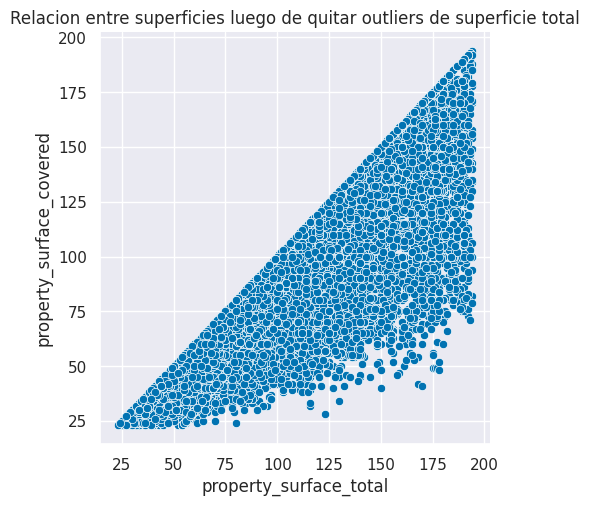

In [97]:
sns.relplot(data=df_sin_outliers, x="property_surface_total", y="property_surface_covered", kind="scatter").set(title="Relacion entre superficies luego de quitar outliers de superficie total")

[Text(0.5, 1.0, 'Sup. cubierta tras quitar outliers')]

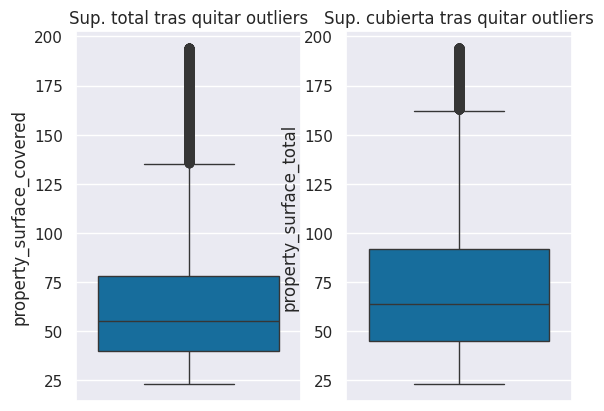

In [98]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df_sin_outliers["property_surface_covered"], ax=ax[0]).set(title="Sup. total tras quitar outliers")
sns.boxplot(y=df_sin_outliers["property_surface_total"], ax=ax[1]).set(title="Sup. cubierta tras quitar outliers")

[Text(0.5, 1.0, 'Correlación entre superficies sin outliers')]

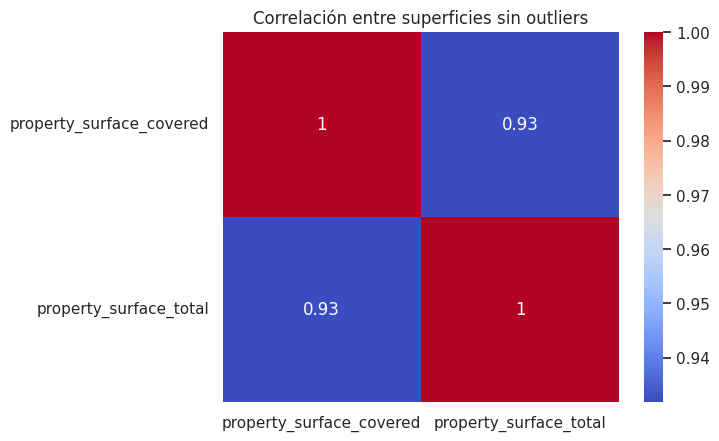

In [99]:
corr = df_sin_outliers[["property_surface_covered", "property_surface_total"]].corr()
sns.heatmap(data=corr, annot=True, cmap="coolwarm").set(title="Correlación entre superficies sin outliers")

[Text(0.5, 1.0, 'Correlación entre superficies con outliers')]

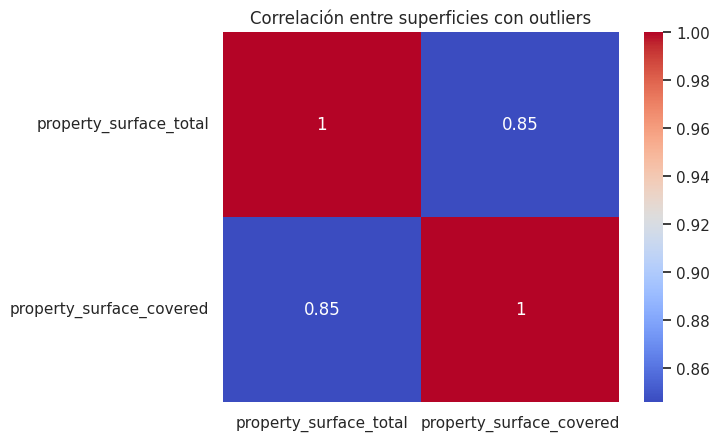

In [100]:
corr = df[["property_surface_total", "property_surface_covered"]].corr()
sns.heatmap(data=corr, annot=True, cmap="coolwarm").set(title="Correlación entre superficies con outliers")

Finalmente, analizamos cómo las modificaciones que se le hicieron al dataset afectaron la distribución de la variable `property_surface_total`.

In [101]:
df = df_sin_outliers

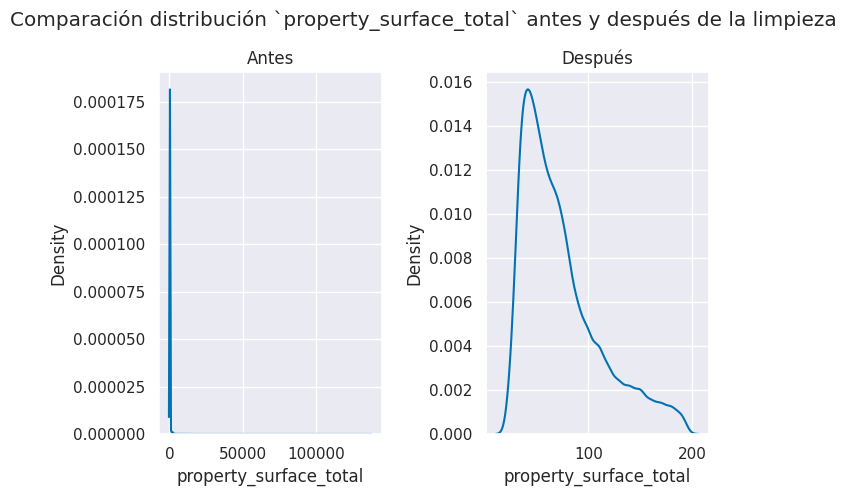

In [102]:
fig, ax = plt.subplots(1, 2)

fig.tight_layout(w_pad=3)
plt.subplots_adjust(top=0.85)

ax[0].set_title("Antes")
ax[1].set_title("Después")

sns.kdeplot(df_pre_limpieza, x="property_surface_total", ax=ax[0])
sns.kdeplot(df, x="property_surface_total", ax=ax[1])

fig.suptitle("Comparación distribución `property_surface_total` antes y después de la limpieza")
plt.show()

#### Rooms y bedrooms

Nuevamente, utilizamos el método de imputación MICE. **TODO: Probar variantes de MICE**

In [103]:
cantidad_rooms_na = len(df[df["property_rooms"].isna()])
cantidad_bedrooms_na = len(df[df["property_bedrooms"].isna()])

print("Cantidad con `property_rooms` nulo:", cantidad_rooms_na)
print("Cantidad con `property_bedrooms` nulo:", cantidad_bedrooms_na)

Cantidad con `property_rooms` nulo: 605
Cantidad con `property_bedrooms` nulo: 9632


In [104]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_rooms = IterativeImputer(random_state=0)
df.loc[:, ["property_rooms", "property_bedrooms"]] = impute_rooms.fit_transform(df[["property_rooms", "property_bedrooms"]])

Luego de imputar las filas nulas, tenemos que tomar en cuenta que los valores de estas columnas deben ser valores enteros, entonces decidimos redondear hacia arriba los valores flotantes que produjo la imputación.

In [105]:
df[["property_rooms", "property_bedrooms"]] = df[["property_rooms", "property_bedrooms"]].transform(np.ceil)

Analizamos las estadísticas de ambas variables luego de la imputación.

In [106]:
df[["property_rooms", "property_bedrooms"]].describe()

property_rooms  property_bedrooms
count    83842.000000       83842.000000
mean         2.628313           1.765774
std          1.121447           0.915381
min          1.000000          -1.000000
25%          2.000000           1.000000
50%          3.000000           2.000000
75%          3.000000           2.000000
max         40.000000          70.000000

Podemos ver que hay algunas propiedades con cantidad de cuartos negativa, lo cual probablemente sea un error de tipeo por lo que su valor de `property_rooms` se asemeja a un valor esperable para una propiedad de 1 bedroom (que es el mismo valor ingresado pero sin el signo negativo). Además la descripción de esta propiedad indica que es un tres ambientes, por lo que los valores de 2 rooms y 1 bedroom encajan a la perfección. Decidimos corregirlo y mantener la fila.

In [107]:
df[df["property_bedrooms"] == -1][["property_rooms", "property_bedrooms", "property_title"]]

property_rooms  property_bedrooms  \
406880             2.0               -1.0   

                                           property_title  
406880  Jardines de Roosevelt - Hermoso 3 ambientes co...

In [108]:
df.loc[406880, "property_bedrooms"] = 1

Visualizamos la relación entre ambas variables para encontrar outliers entre ellas.

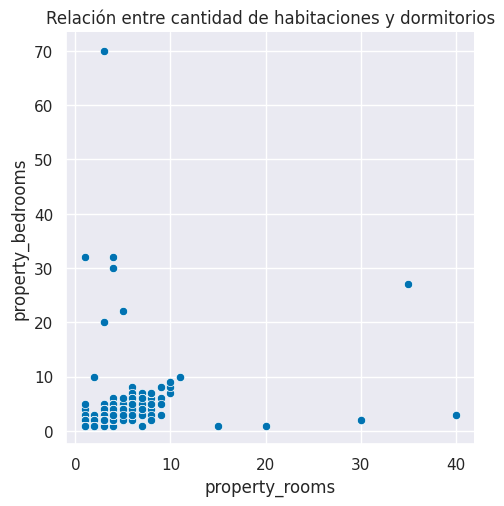

In [109]:
sns.relplot(data=df, x="property_rooms", y="property_bedrooms", kind="scatter").set(title="Relación entre cantidad de habitaciones y dormitorios")

Este gráfico nos aporta información muy importante sobre los outliers en conjunto de estas dos variables. Acá podemos ver que los valores extremos de `property_rooms` y `property_bedrooms` no están tan relacionados, como sí sucedía con la áreas. Los valores extremos de `property_rooms` (salvo 1) no tienen un valor de `property_bedrooms` muy elevado, y viceversa.

In [110]:
df[(df["property_rooms"] > 31) & (df["property_bedrooms"] > 25)]

id  start_date    end_date    latitud  \
150885  X3WGOe/PrGS1u+xozM5elA==  2021-03-24  2021-06-05 -34.642037   

         longitud     neighbourhood property_type  property_rooms  \
150885 -58.438995  Parque Chacabuco  Departamento            35.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
150885               27.0                    37.0                      33.0   

        property_price                                     property_title  
150885         67000.0  Venta Departamento monoambiente balcón full am...

La misma descripción nos indica que esta propiedad es un monoambiente, por lo que corregimos los valores de la cantidad de cuartos y habitaciones.

In [111]:
df.loc[150885, 'property_rooms'] = 1
df.loc[150885, 'property_bedrooms'] = 1

Luego analizamos los outliers de manera univariada.

[Text(0.5, 1.0, 'Cantidad de dormitorios')]

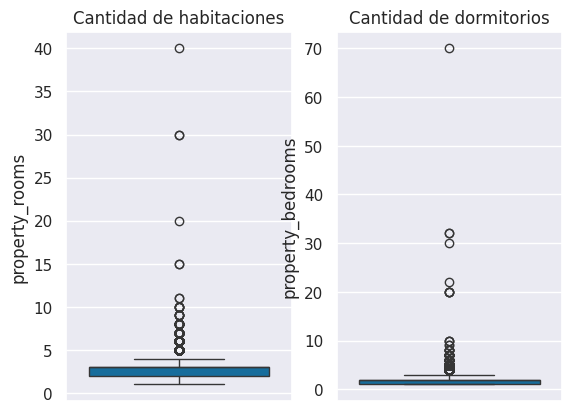

In [112]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df["property_rooms"], ax=ax[0]).set(title="Cantidad de habitaciones")
sns.boxplot(y=df["property_bedrooms"], ax=ax[1]).set(title="Cantidad de dormitorios")

Observamos el resto de valores extremos de `property_bedrooms`.

In [113]:
df[df["property_bedrooms"] > 15][["property_rooms", "property_bedrooms", "property_title"]]

property_rooms  property_bedrooms  \
36421              3.0               20.0   
48279              4.0               32.0   
49960              1.0               32.0   
86014              4.0               30.0   
94998              3.0               70.0   
140832             5.0               22.0   
337147             3.0               20.0   
337149             3.0               20.0   
337831             3.0               20.0   

                                           property_title  
36421                              Departamento - Palermo  
48279   Departamento 4 ambientes a estrenar en duplex ...  
49960            Depto 1 ambiente amplio apto profesional  
86014   Departamento. Recoleta. Balcón terraza. Silenc...  
94998                           Departamento - Villa Luro  
140832  Departamento de 2 dormitorios con balcón en ve...  
337147  Excelente y único Departamento en duplex a nue...  
337149  Excelente y único Departamento en duplex a nue...  
337831  Excelente y único Departamento en duplex a nue...

Entre los registros observados, consideramos rescatables aquel cuya descripción indica que es un monoambientes y la que dice explícitamente que la propiedad tiene 2 dormitorios.

In [114]:
df.loc[49960, ["property_rooms", "property_bedrooms"]] = 1
df.loc[140832, "property_bedrooms"] = 2

Ahora observamos los valores extremos de `property_rooms`.

In [115]:
df[df["property_rooms"] > 12][["property_rooms", "property_bedrooms", "property_title"]]

property_rooms  property_bedrooms  \
21009             30.0                2.0   
52157             30.0                2.0   
122415            15.0                1.0   
211468            20.0                1.0   
356618            40.0                3.0   
436374            15.0                1.0   

                                           property_title  
21009     C/DEP COCH Y BAULERA - SEGUI AL 700 - Caballito  
52157                              PH - Parque Avellaneda  
122415                                     PH - San Telmo  
211468                       Departamento - Puerto Madero  
356618  SOLER 4400 - PALERMO - DPTO 4 AMB C/ BALCON AL...  
436374  Departamento  en venta de 37.20 m2 un ambiente...

Todos, salvo los que dicen que tienen 15 cuartos, podrían ser errores de tipeo, en los que se agregó un cero demás al ingresar los dígitos del valor real de `property_rooms`. Optamos por corregirlos y dropear los que tienen un valor de 15.

In [116]:
df = df.drop([122415, 436374])
df.loc[df["property_rooms"] > 12, "property_rooms"] = df[df["property_rooms"] > 12]["property_rooms"] / 10

También nos interesa saber si hay propiedades con más bedrooms que rooms. Encontramos algunos registros con esta condición, pero como son pocos los dropeamos.

In [117]:
len(df[df["property_rooms"] < df["property_bedrooms"]])

102

In [118]:
df = df.drop(df[df["property_rooms"] < df["property_bedrooms"]].index)

Finalmente, al igual que a como hicimos con las variables de área, luego de visualizar nuevamente los boxplots, decimos dropear los outliers que la métrica de las distancia intercuartil considere como tales.

[Text(0.5, 1.0, 'Cantidad de dormitorios')]

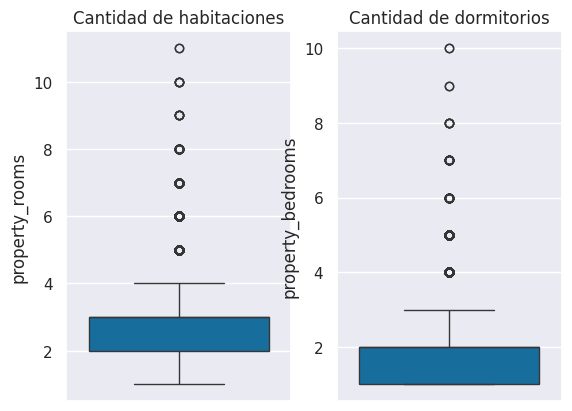

In [119]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df["property_rooms"], ax=ax[0]).set(title="Cantidad de habitaciones")
sns.boxplot(y=df["property_bedrooms"], ax=ax[1]).set(title="Cantidad de dormitorios")

En este caso optamos por utilizar el z-score modificado como métrica para eliminar outliers.

In [120]:
def z_score_mod(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

In [121]:
df = df.drop(df[(z_score_mod(df["property_rooms"]) > 3.5) | (z_score_mod(df["property_bedrooms"]) > 3.5)].index)

Visualizamos como quedan las distribuciones conjuntas de estas variables y sus outliers. Como las cantidad de cuartos son variables discretas, utilizamos un gráfico de barras en vez de un scatterplot.

[Text(0.5, 1.0, 'Registros por cantidad de cuartos o dormitorios')]

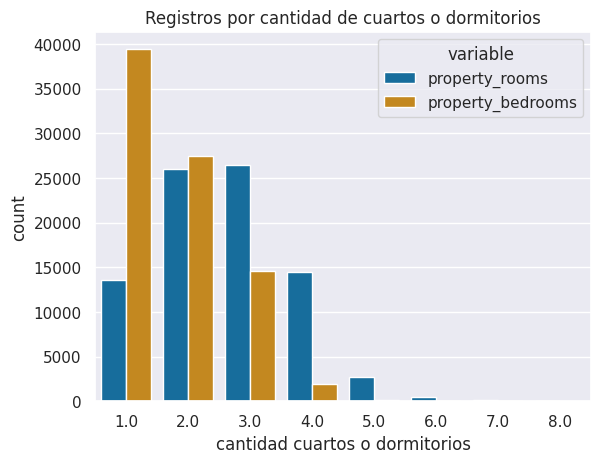

In [122]:
df_long = pd.melt(df, value_vars=["property_rooms", "property_bedrooms"], var_name="variable", value_name="cantidad cuartos o dormitorios")
sns.countplot(data=df_long, x="cantidad cuartos o dormitorios", hue="variable").set(title="Registros por cantidad de cuartos o dormitorios")

Nos llama la atención el que el gráfico distribución nos está diciendo que es una tail-heavy distribution. Las cantidades de propiedades con un número elevado de cuartos y habitaciones son pocas, pero técnicamente no son considerados como outliers con las métricas utilizadas, y tras una inspección manual, vemos que bastantes de estos valores son propiedades que tiene sentido, por ejemplo, muchas de las que tiene 8 cuartos, indican en su descripción que son propiedades de 8 ambientes.

In [123]:
df[df["property_rooms"] == 8]

id  start_date    end_date    latitud  \
1800    xOxObQG9UHaTxLPYGOtK4w==  2021-12-17  2022-02-09 -34.616128   
43279   QxsB9Jhwt9BtwsX0Zobd1w==  2021-11-23  2021-12-21 -34.616935   
59919   sc0VciOEM3mYU/C0dXAR2Q==  2021-01-25  2021-06-05 -34.655198   
74058   0mycft4Dy3FaSpULNEt6HA==  2021-07-03  2021-08-11 -34.616128   
86634   RXB/eXmIK3FBKzyhFO344g==  2021-03-26  2021-04-26 -34.665193   
94758   IcX9fpFRmmNTKfmbAv3IUA==  2021-09-24  2022-02-09 -34.616128   
104397  Pk6htkGcY8RZB+ftXuKIFA==  2021-09-10  2021-11-24 -34.616935   
122361  ZU4weyooCsXHV2OZ05OB6Q==  2021-09-25  2022-02-09 -34.629841   
122433  YYZKf8AY2R/QkDIJzqivKQ==  2021-08-04  2021-09-10 -34.616935   
160647  g2lVFbAOcrS2z7wcJsXufQ==  2021-10-07  2022-03-09 -34.618293   
171773  NuaZvptiWeobeUjsZ6gDyw==  2021-12-20  2022-01-27 -34.616935   
179286  2Qvq3+KZaXo+fNNTMXfnHQ==  2021-02-02  2021-04-03 -34.640508   
183827  z2lw5AlAAmGf5mfakaLR1g==  2021-04-18  2021-10-03 -34.603298   
203290  djuNHT5tLnO2yVXK679/mw==  2021-05-10  2021-06-05 -34.616981   
213386  eC5rqzvLrOReWCX2O+cmkg==  2021-06-03  2021-06-05 -34.596130   
228092  aGEAhgmOQjBj3ptYVsEj/A==  2021-02-12  9999-12-31 -34.592341   
246860  hC7E4PhJ46QjegKDubmtlg==  2021-10-08  9999-12-31 -34.610041   
266748  x7I7jCPpA3LOAPYvgxzmbQ==  2021-09-02  2022-01-27 -34.603297   
280130  Tuxc8TkCHv9Ue7iFt6IGOQ==  2021-07-12  2021-12-18 -34.600387   
280159  CBT/6xNDUyYTbLmDyJBSJA==  2021-07-12  9999-12-31 -34.652062   
280302  g/GmPLlCbZkp1319gEqksw==  2021-07-12  2021-12-18 -34.600387   
291391  kxr9R2CIX0Kkx+A9Ip1Ayg==  2021-02-22  2022-06-11 -34.592874   
297098  v693ci662IceB3yI7DAQNw==  2021-04-26  9999-12-31 -34.602325   
306582  r2lxA6uMdDjqbxbhBbjADw==  2021-03-04  2021-06-05 -34.603360   
319683  jWHZld0vCtemyjpDhQTw6g==  2021-01-30  2021-02-18 -34.602228   
324996  EpT3RaAkNyEWsSbR+1+YBg==  2021-03-03  2021-04-30 -34.603083   
331525  X9jsyknsuCuHNBef06vk7Q==  2021-01-01  2021-01-02 -34.629600   
341999  icm+UwNVdxNPQSwZ4R3CVw==  2021-09-28  2021-09-28 -34.606582   
342818  mqoxNDn8Gn/UkxbHPo7iOA==  2021-08-11  2021-09-01 -34.616128   
351451  WK2soZ5KBGW4HeonJ71HSw==  2021-06-25  2021-08-02 -34.616935   
383324  jrHFWarlhUgF+25jho+WNA==  2021-04-27  2021-09-30 -34.665193   
428443  VySBwie6GZPho7IK0pM/ww==  2021-12-16  2022-02-09 -34.616128   
439064  5jWVAodcZ9d6tVGrcMV3iA==  2021-04-23  2021-07-03 -34.616128   
445471  2loPBHwCsXTfQjAYEi8f1w==  2021-05-20  2021-05-20 -34.610156   

         longitud neighbourhood property_type  property_rooms  \
1800   -58.394715     Balvanera          Casa             8.0   
43279  -58.522459    Villa Real            PH             8.0   
59919  -58.376904      Barracas            PH             8.0   
74058  -58.394715     Balvanera          Casa             8.0   
86634  -58.477331  Villa Lugano          Casa             8.0   
94758  -58.394715     Balvanera          Casa             8.0   
104397 -58.522459    Villa Real            PH             8.0   
122361 -58.383624  Constitución            PH             8.0   
122433 -58.522459    Villa Real            PH             8.0   
160647 -58.420633       Almagro            PH             8.0   
171773 -58.522459    Villa Real            PH             8.0   
179286 -58.454510        Flores          Casa             8.0   
183827 -58.393633     Balvanera  Departamento             8.0   
203290 -58.371730     San Telmo            PH             8.0   
213386 -58.485127     Agronomía          Casa             8.0   
228092 -58.390858      Recoleta  Departamento             8.0   
246860 -58.402398     Balvanera  Departamento             8.0   
266748 -58.393641     Balvanera  Departamento             8.0   
280130 -58.398776     Balvanera  Departamento             8.0   
280159 -58.498908     Mataderos          Casa             8.0   
280302 -58.398776  Barrio Norte  Departamento             8.0   
291391 -58.377872        Retiro  Departamento             8.0   
297098 -58.434659  Villa Crespo  Departamento    

Tras el filtro utilizando el z-score, los boxplots nos quedan de la siguiente manera:

[Text(0.5, 1.0, 'Cant. dormitorios tras quitar outliers')]

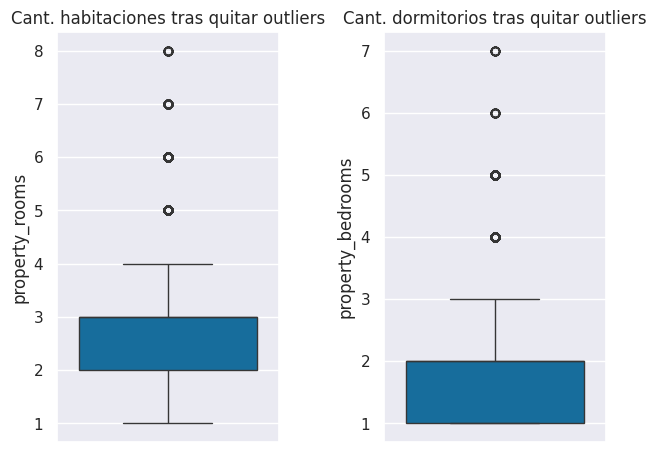

In [124]:
fig, ax = plt.subplots(1, 2);
fig.tight_layout(w_pad=3)

sns.boxplot(y=df["property_rooms"], ax=ax[0]).set(title="Cant. habitaciones tras quitar outliers")
sns.boxplot(y=df["property_bedrooms"], ax=ax[1]).set(title="Cant. dormitorios tras quitar outliers")

Adicionalmente visualizamos las distribuciones de ambas variables para ver como la eliminación de los outliers y la imputación de datos faltantes afectó a las mismas.

In [125]:
def visualizar_dist_rooms(variable):
  fig, ax = plt.subplots(1, 2);
  fig.tight_layout(w_pad=3)
  plt.subplots_adjust(top=0.85)

  ax[0].set_title("Antes")
  ax[1].set_title("Después")

  max_rooms_pre = int(df_pre_limpieza[variable].max())
  ax[0].set_xticks(np.arange(0, max_rooms_pre, step=1))
  tick_labels = ['' if i % 10 != 0 else str(i) for i in range(max_rooms_pre)]
  ax[0].set_xticklabels(tick_labels)

  sns.countplot(df_pre_limpieza, x=variable, ax=ax[0])
  sns.countplot(df, x=variable, ax=ax[1])

  fig.suptitle(f"Comparación distribución `{variable}` antes y después de la limpieza")

  plt.show()

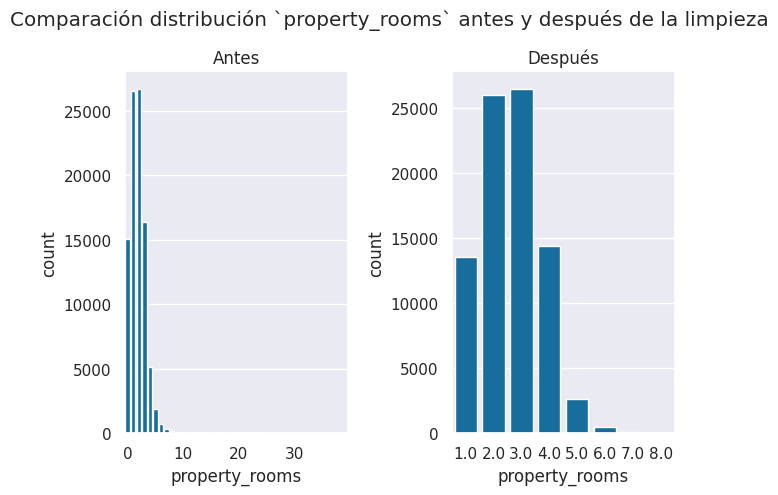

In [126]:
visualizar_dist_rooms("property_rooms")

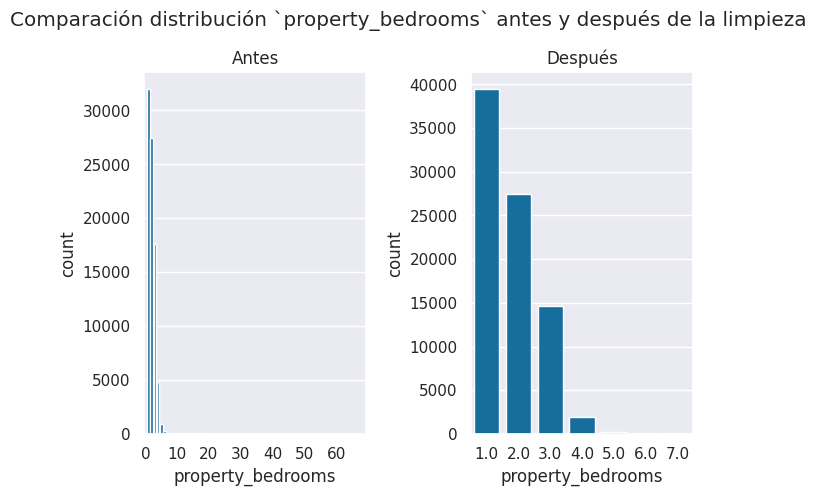

In [127]:
visualizar_dist_rooms("property_bedrooms")

#### Precio

Finalmente, también nos interesa conocer si nuestra variable de salida posee outliers. Esto podría afectar significativamente los resultados de las predicciones numéricas. Para eso visualizamos su boxplot.

[Text(0.5, 1.0, 'Outliers de precios')]

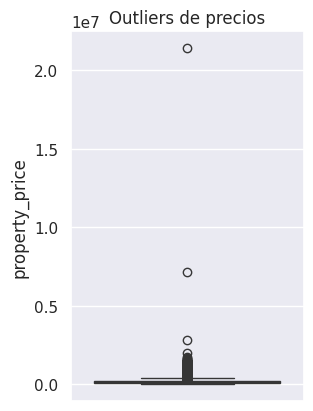

In [128]:
plt.figure().set_figwidth(3)
sns.boxplot(y=df["property_price"]).set(title="Outliers de precios")

A partir del gráfico, podemos ver que hay pocos outliers significativos. Entre los que destacan principalmente aquellas propiedades con precios superiores a los 2.5 millones de dólares. Debido a que solamente son dos, y afectan mucho las estadísticas del precio, decidimos dropearlas.

In [129]:
df[df["property_price"] > 1_500_000]

id  start_date    end_date    latitud  \
3988    bMbo9CdhczvF3IY5329LVg==  2021-02-20  2021-09-11 -34.611004   
12693   Rai630DR8kl4Hpx4v/eoRQ==  2021-07-06  2022-09-02 -34.617382   
26442   KiatYK8W9d4pKlodAIq39Q==  2021-06-24  2021-06-30 -34.612338   
60073   uoM9HDKq3jZKQKgHXTIGkg==  2021-01-25  2022-05-13 -34.616044   
72334   33IKLDyUAVVhF/Ek5J68xA==  2021-05-29  2021-05-31 -34.579757   
306829  nH/Kmmg1djAa7Wbrm742qA==  2021-03-04  2021-06-05 -34.616918   
358992  lFFdgy24/RSnbpQB0h6RGA==  2021-06-29  2021-07-12 -34.611545   
365497  CIF7tltSXhj6CyOyi++0Pw==  2021-04-10  2021-06-03 -34.582031   
401318  2Z5VCCq2CSNrF2FcGJnWjg==  2021-06-17  2021-09-05 -34.551243   

         longitud  neighbourhood property_type  property_rooms  \
3988   -58.361275  Puerto Madero  Departamento             3.0   
12693  -58.361645  Puerto Madero  Departamento             4.0   
26442  -58.360972  Puerto Madero  Departamento             4.0   
60073  -58.458621      Caballito  Departamento             3.0   
72334  -58.408121        Palermo  Departamento             5.0   
306829 -58.359927  Puerto Madero  Departamento             3.0   
358992 -58.360198  Puerto Madero  Departamento             3.0   
365497 -58.432021        Palermo  Departamento             4.0   
401318 -58.455105          Nuñez  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
3988                  2.0              155.110691                140.000000   
12693                 3.0              155.110691                140.000000   
26442                 3.0              161.000000                121.053298   
60073                 2.0               68.000000                 64.000000   
72334                 3.0              170.000000                170.000000   
306829                2.0              128.000000                118.000000   
358992                2.0              164.000000                152.000000   
365497                3.0              162.000000                150.000000   
401318                1.0               56.000000                 47.000000   

        property_price                                     property_title  
3988         2000000.0                       Departamento - Puerto Madero  
12693        1600000.0                       Departamento - Puerto Madero  
26442        1750000.0                     Departamento - Capital Federal  
60073       21400000.0                                 Departamento venta  
72334        1645000.0  Vista panorámica, 170 m², 3 dormitorios, ameni...  
306829       7149999.0                       Departamento - Puerto Madero  
358992       1595000.0   VENTA ESPECTACULAR UNIDAD EN ALVEAR TOWER 2 C...  
365497       1550000.0  Departamento Torre Mirabilia - 4 Ambientes con...  
401318       2790000.0      Venta departamento 2 ambientes Nuñez Financio

In [130]:
df = df.drop(df[df["property_price"] > 2_500_000].index)

Finalmente, visualizamos los boxplots de los precios tras eliminar estos outliers extremos.

[Text(0.5, 1.0, 'Outliers de precios')]

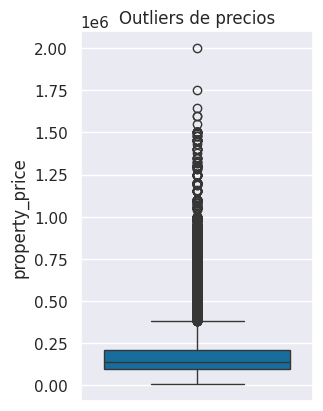

In [131]:
plt.figure().set_figwidth(3)
sns.boxplot(y=df["property_price"]).set(title="Outliers de precios")

#### Relación precio y área

Finalmente analizamos las correlaciones entre las variables luego de lidiar con los outliers y manejar los datos nulos.

[Text(0.5, 1.0, 'Correlación entre variables')]

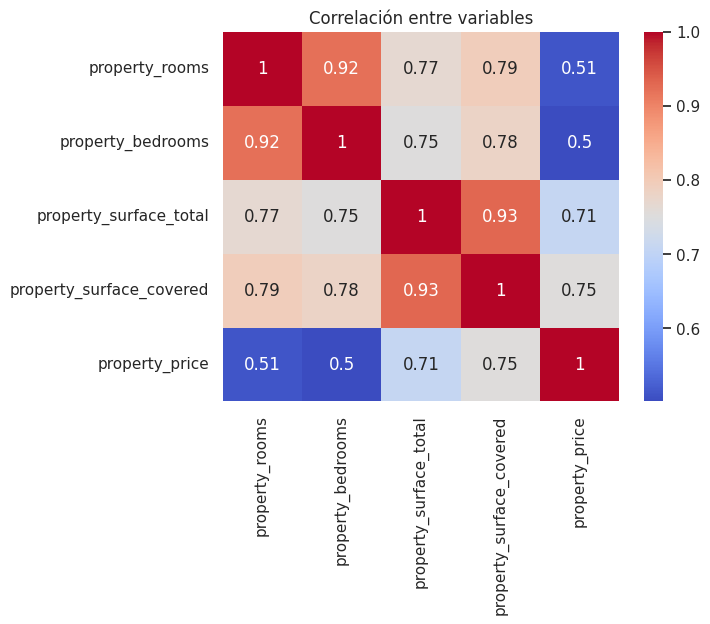

In [132]:
corr = df.select_dtypes(include="number").drop(["latitud", "longitud"], axis="columns").corr()
sns.heatmap(data=corr, annot=True, cmap="coolwarm").set(title="Correlación entre variables")

Notamos que las dos variables que mayor correlación tienen con el precio son las variables que nos aportan información sobre la superficie de la propiedad, particularmente `property_surface_covered`. Podemos visualizar la relación entre estas dos variables para comprender un poco mejor cómo se correlacionan.

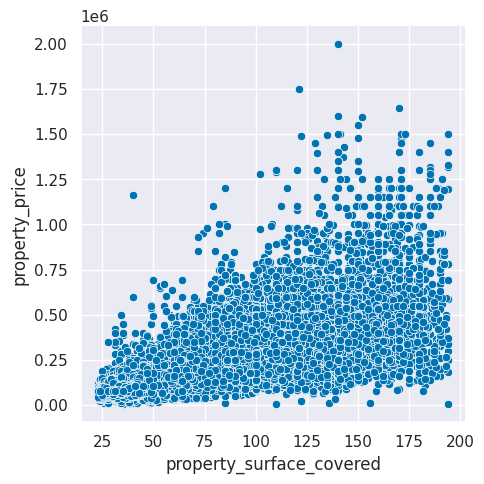

In [133]:
sns.relplot(data=df, x="property_surface_covered", y="property_price", kind="scatter")

Tal como nos indica el coeficiente de correlación de Pearson, ambas variables tienen una relación positiva, que vemos que es más ajustada para valores bajos de superficie cubierta. A valores de superficie más grandes, la variación de precios es mayor, sin embargo no llegamos a considerar ninguna de estas muestras como outliers multivariados, sino solamente como propiedades con altos precios, que puede ser consecuencia de las demás variables más allá de la superficie de la misma.

# Agrupamiento

Para empezar con la sección de clustering, consideramos oportuno mostrar un gráfico con toda la data antes de ser dividida en clusters.

In [ ]:
def scatter_df(df, title):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(projection='3d')

  xs = df['property_rooms']
  ys = df['property_surface_total']
  zs = df['property_price']
  ax.scatter(xs, ys, zs, marker='x')

  ax.set_xlabel('Rooms')
  ax.set_ylabel('Total Surface')
  ax.set_zlabel('Price')
  ax.set(title=title)

  plt.show()

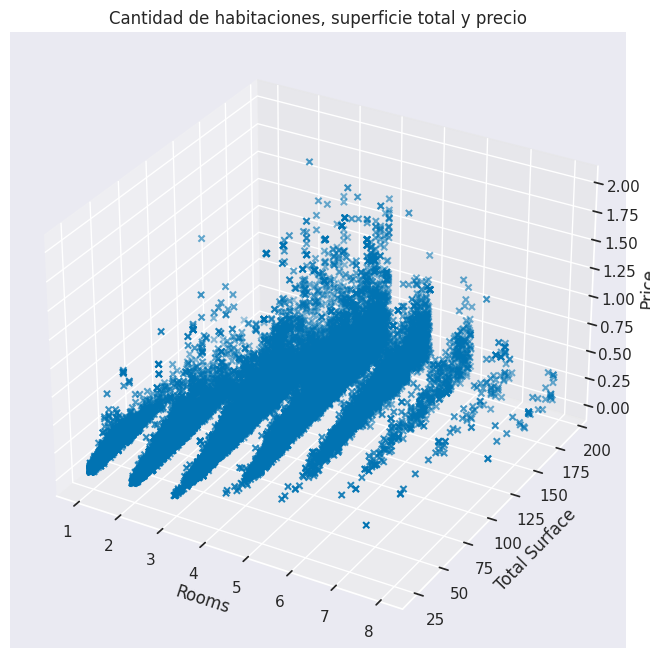

In [ ]:
scatter_df(df, "Cantidad de habitaciones, superficie total y precio")

### Tendencia al clustering

KMeans encuentra clusters incluso en datos con una distribución uniforme, con lo cual usarlo sin un previo análisis de la tendencia al clustering del dataset no tendría mucho sentido, porque los grupos no significarían nada. Para hacer este análisis, usamos la estadística de Hopkins.

Necesitamos quedarnos con las columnas numéricas del dataframe para que la función no tenga problemas con los valores no numéricos. También, exceptuamos la latitud y la longitud para quedarnos con variables que puedan ser facilmente comparables.

In [ ]:
from typing import Union
from sklearn.neighbors import BallTree

def hopkins(data_frame: Union[np.ndarray, pd.DataFrame]) -> float:
  sampling_size = df.shape[0]

  if type(data_frame) == np.ndarray:
    data_frame = pd.DataFrame(data_frame)

  data_frame_sample = sample_observation_from_dataset(data_frame, sampling_size)

  sample_distances_to_nearest_neighbours = get_distance_sample_to_nearest_neighbours(
    data_frame, data_frame_sample
  )

  uniformly_selected_observations_df = simulate_df_with_same_variation(
    data_frame, sampling_size
  )

  df_distances_to_nearest_neighbours = get_nearest_sample(
    data_frame, uniformly_selected_observations_df
  )

  x = sum(sample_distances_to_nearest_neighbours)
  y = sum(df_distances_to_nearest_neighbours)

  if x + y == 0:
    raise Exception("The denominator of the hopkins statistics is null")

  return x / (x + y)[0]


def get_nearest_sample(df: pd.DataFrame, uniformly_selected_observations: pd.DataFrame):
  tree = BallTree(df, leaf_size=2)
  dist, _ = tree.query(uniformly_selected_observations, k=1)
  uniformly_df_distances_to_nearest_neighbours = dist
  return uniformly_df_distances_to_nearest_neighbours


def simulate_df_with_same_variation(
  df: pd.DataFrame, sampling_size: int
) -> pd.DataFrame:
  max_data_frame = df.max()
  min_data_frame = df.min()
  uniformly_selected_values_0 = np.random.uniform(
    min_data_frame[0], max_data_frame[0], sampling_size
  )
  uniformly_selected_values_1 = np.random.uniform(
    min_data_frame[1], max_data_frame[1], sampling_size
  )
  uniformly_selected_observations = np.column_stack(
    (uniformly_selected_values_0, uniformly_selected_values_1)
  )
  if len(max_data_frame) >= 2:
    for i in range(2, len(max_data_frame)):
      uniformly_selected_values_i = np.random.uniform(
        min_data_frame[i], max_data_frame[i], sampling_size
      )
      to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
      uniformly_selected_observations = np.column_stack(to_stack)
  uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
  return uniformly_selected_observations_df


def get_distance_sample_to_nearest_neighbours(df: pd.DataFrame, data_frame_sample):
  tree = BallTree(df, leaf_size=2)
  dist, _ = tree.query(data_frame_sample, k=2)
  data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
  return data_frame_sample_distances_to_nearest_neighbours


def sample_observation_from_dataset(df, sampling_size: int):
  if sampling_size > df.shape[0]:
    raise Exception("The number of sample of sample is bigger than the shape of D")
  data_frame_sample = df.sample(n=sampling_size)
  return data_frame_sample

In [ ]:
hopkins(df[['property_rooms', 'property_surface_total', 'property_price']])

0.0008418244894734905

En la implementación de la librería `pyclustertend` se indica que, usando el método `hopkins`, un valor más cercano a 0 implica una mayor tendencia a la clusterización. En nuestro caso, se puede ver una fuerte tendencia al clustering, con lo cual podemos proceder a usar KMeans para encontrar clusters en nuestro dataset.

### Cantidad óptima de grupos

Para evaluar la cantidad óptima de grupos que se deben formar, aplicamos KMeans varias veces y calculamos el coeficiente de Silhouette promedio de toda la muestra en cada ocasión.


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

lista_distintos_k = range(2, 10)
data = df[['property_rooms', 'property_surface_total', 'property_price']]

scores = {}
best_n_clusters = lista_distintos_k[0]

for n_clusters in lista_distintos_k:
  clusterer = KMeans(n_clusters=n_clusters, n_init='auto')
  preds = clusterer.fit_predict(data)
  score = silhouette_score(data, preds)
  scores[n_clusters] = score

  if score > scores[best_n_clusters]:
    best_n_clusters = n_clusters

  print("Para n_clusters=" + str(n_clusters) + ", el score de silhouette es " + str(score))

print(f"Cantidad de clusters más óptima: {best_n_clusters}")

Para n_clusters=2, el score de silhouette es 0.7330960014708091
Para n_clusters=3, el score de silhouette es 0.6479965030654605
Para n_clusters=4, el score de silhouette es 0.6043549204720139
Para n_clusters=5, el score de silhouette es 0.5978689985683056
Para n_clusters=6, el score de silhouette es 0.5580840223403194
Para n_clusters=7, el score de silhouette es 0.5635337104419204
Para n_clusters=8, el score de silhouette es 0.5562196901973214
Para n_clusters=9, el score de silhouette es 0.5508764388362297
Cantidad de clusters más óptima: 2


Nos quedamos con dos grupos, que es la cantidad cuyo coeficiente de Silhouette es el más cercano a 1. Pareciera que a medida que intentamos con más grupos, el coeficiente cae.

Entonces, aplicamos KMeans para que encuentre dos clusters en nuestro dataframe, y lo graficamos.

In [ ]:
COLORES_GRUPOS = 'plasma'

def kmean_scatter_plot(df=None, clusters=2, title=None, elev=None, axim=None, roll=None):
  labels = KMeans(clusters, random_state=0, n_init='auto').fit_predict(df[['property_rooms', 'property_surface_total', 'property_price']])

  fig = plt.figure(figsize=(8,10))

  ax = fig.add_subplot(projection='3d')
  ax.view_init(elev=elev, azim=axim, roll=roll)

  xs = df['property_rooms']
  ys = df['property_surface_total']
  zs = df['property_price']
  ax.scatter(xs, ys, zs, marker='.', c=labels, cmap=COLORES_GRUPOS)

  ax.set_xlabel('Rooms')
  ax.set_ylabel('Total Surface')
  ax.set_zlabel('Price')
  ax.set(title=title)

  plt.show()

  return labels

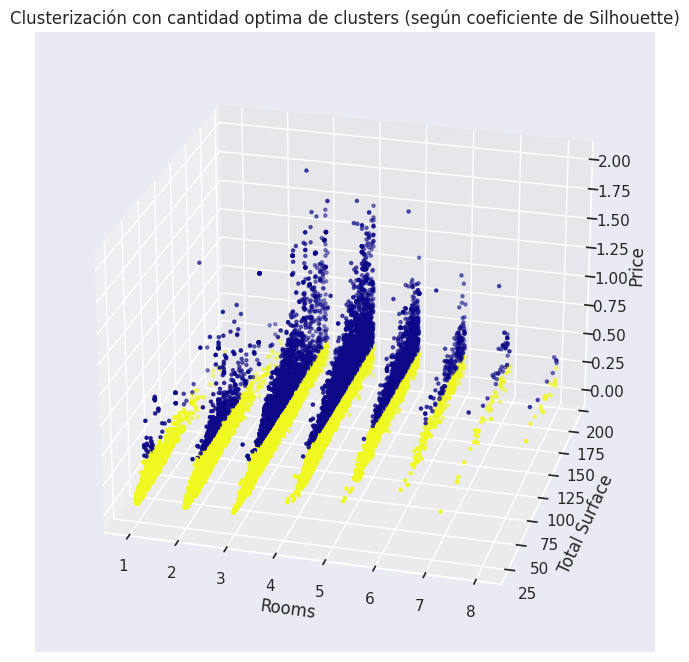

In [ ]:
clusters = kmean_scatter_plot(df, best_n_clusters, "Clusterización con cantidad optima de clusters (según coeficiente de Silhouette)", elev=25, axim=-75, roll=0)
clustered_df = df.assign(cluster=clusters)

Pareciera que la variable más significativa fue el precio. Viendo el scatterplot desde un lado, se ve una clara división a partir de ciertos precios, como si hubiese un plano horizontal que corta los datos.

In [ ]:
first_cluster = clustered_df[clustered_df['cluster'] == 0]
second_cluster = clustered_df[clustered_df['cluster'] == 1]

In [ ]:
first_cluster.describe().apply(lambda s: s.apply('{0:.5f}'.format))

latitud     longitud property_rooms property_bedrooms  \
count  10219.00000  10219.00000    10219.00000       10219.00000   
mean     -35.89471    -57.11541        3.75506           2.64683   
std        5.43196      5.43406        0.87873           0.76938   
min      -58.50350    -58.52526        1.00000           1.00000   
25%      -34.60329    -58.44837        3.00000           2.00000   
50%      -34.58660    -58.42272        4.00000           3.00000   
75%      -34.56976    -58.39223        4.00000           3.00000   
max      -34.53674    -34.54348        8.00000           7.00000   

      property_surface_total property_surface_covered property_price  \
count            10219.00000              10219.00000    10219.00000   
mean               131.54692                116.92378   451882.82004   
std                 33.64095                 32.21240   181113.24129   
min                 37.00000                 28.00000   294500.00000   
25%                108.00000                 94.00000   335000.00000   
50%                130.96940                115.00000   390000.00000   
75%                158.00000                140.00000   498000.00000   
max                194.00000                194.00000  2000000.00000   

           cluster  
count  10219.00000  
mean       0.00000  
std        0.00000  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        0.00000  
max        0.00000

In [ ]:
second_cluster.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  73503.000000  73503.000000    73503.000000       73503.000000   
mean     -35.322754    -57.715221        2.468253           1.636069   
std        4.093733      4.097189        1.025880           0.776769   
min      -58.526039    -58.530391        1.000000           1.000000   
25%      -34.619351    -58.467533        2.000000           1.000000   
50%      -34.598910    -58.439268        2.000000           1.000000   
75%      -34.579438    -58.408762        3.000000           2.000000   
max      -34.535964    -34.543481        8.000000           7.000000   

       property_surface_total  property_surface_covered  property_price  \
count            73503.000000              73503.000000    73503.000000   
mean                65.770117                 56.285490   136923.884658   
std                 30.410424                 24.110315    59158.941099   
min                 23.000000                 23.000000     5000.000000   
25%                 43.000000                 38.000000    89182.000000   
50%                 59.000000                 50.000000   125000.000000   
75%                 80.000000                 68.000000   174900.000000   
max                194.000000                194.000000   294000.000000   

       cluster  
count  73503.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

Viendo estos datos de ambos clusters podemos empezar a obtener información sobre los mismos. Lo primero que se destaca es que el cluster 0 tiene mucha menos cantidad de integrantes que el cluster 1: 10219 a 73503, respectivamente. También, es notable que los precios del cluster 0 son mayores a los del 1, como se evidencia cuando se mira los valores máximos y los promedios de ambos. Esta tendencia parece mantenerse en los promedios de las demás columnas.

En base a los valores máximos y mínimos del `property_price`, podemos darnos cuenta de que el cluster 0 es el que está representado en azul en el gráfico, y el otro es el amarillo. Los valores máximos y mínimos de las demás columas son muy similares, pero en el precio la diferencia es muy notoria. El precio máximo del cluster 1 se encuentra por debajo del precio mínimo del cluster 0, con lo cual la división que encontró KMeans se vio muy influenciada por esa columna.

Con toda esta información, concluimos que el cluster 0 está conformado por las propiedades más costosas y generalmente más espaciosas, que resultan también ser las menos numerosas; mientras que el cluster 1 está formado por las propeidades menos costosas y más pequeñas, que resultan conformar la mayor parte del dataset.

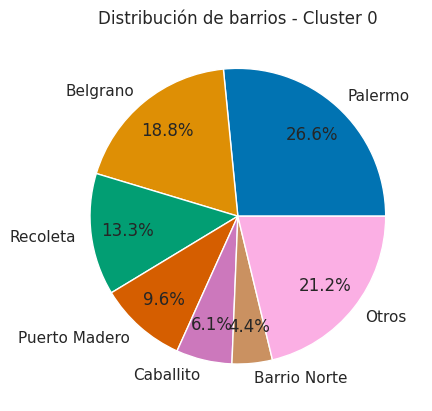

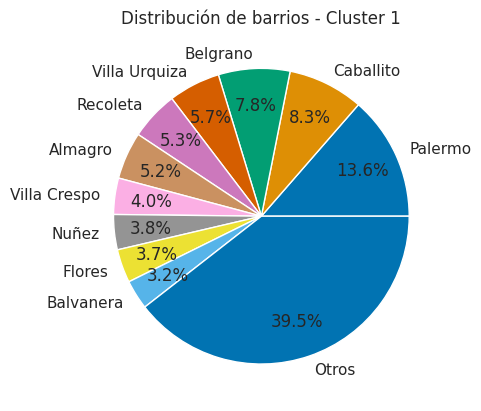

In [ ]:
plt.figure(0)
distribucion_barrios(first_cluster, 6, "Distribución de barrios - Cluster 0")
plt.figure(1)
distribucion_barrios(second_cluster, 10, "Distribución de barrios - Cluster 1")
plt.show()

Un descubrimiento interesante es que la distribución de barrios es notoriamente distinta entre los grupos. El cluster 0 se encuentra conformado principalmente por propiedades ubicadas en los barrios de Palermo, Belgrano, Recoleta y Puerto Madero, que representan un 68% del total. Sin embargo, para el cluster 1, Puerto Madero y Recoleta se ven desplazados por Caballito y Villa Urquiza, mientras que los demás ven sus porcentajes drásticamente reducidos.

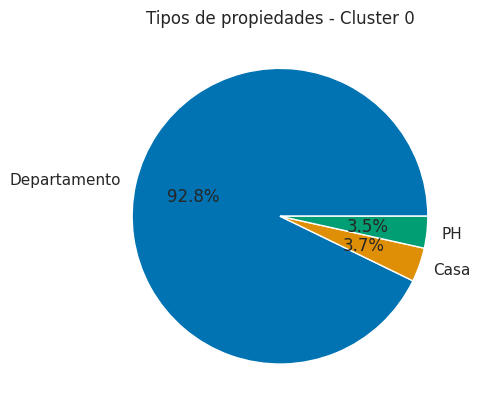

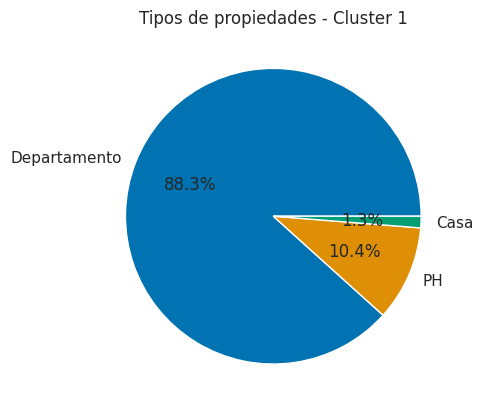

In [ ]:
plt.figure(0)
distribucion_property_type(first_cluster, "Tipos de propiedades - Cluster 0")
plt.figure(1)
distribucion_property_type(second_cluster, "Tipos de propiedades - Cluster 1")
plt.show()

Respecto de los tipos de propiedades, en ambos clusters hay una notoria mayoría de departamentos. Resalta que en el cluster 0, hay una cantidad de casas y PHs similares, pero en el otro hay una mucho mayor presencia de PHs.

### Datos sobre mapa de CABA

Si graficaramos estos datos sobre un mapa, por como quedaron formados los clusters, podríamos ver como se reparten los precios de las viviendas en las diferentes zonas de CABA.

Para poder hacer esto, primero hay que verificar que los datos de latitudes y longitudes sean correctos. Para eso, hacemos un boxplot de cada uno.

[Text(0.5, 1.0, 'Longitud')]

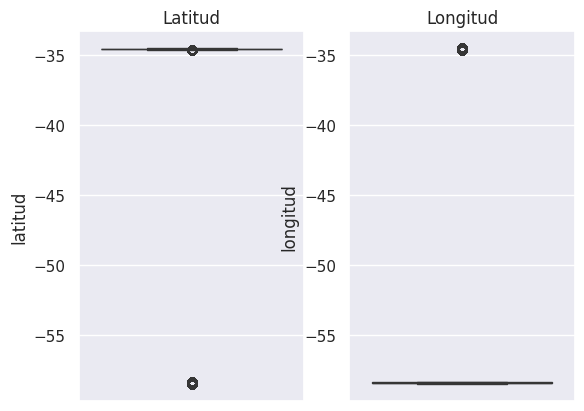

In [ ]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df["latitud"], ax=ax[0]).set(title="Latitud")
sns.boxplot(y=df["longitud"], ax=ax[1]).set(title="Longitud")

Ambos boxplots muestran grupos de outliers muy definidos. Lo curioso es que los outliers de uno parecen ubicarse en los valores donde se encuentra el promedio del otro. Esto pareciera indicar que la latitud y la longitud en los outliers están invertidas. Con lo cual, procedemos a acomodar esos datos.

[Text(0.5, 1.0, 'Longitud reparada')]

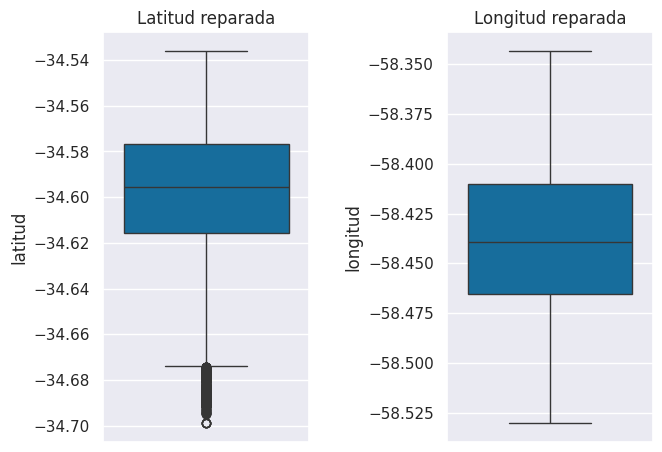

In [ ]:
latitudes_errones = df['latitud'] < -50

longitudes = df[latitudes_errones]['longitud']
df.loc[latitudes_errones, 'longitud'] = df[df['latitud'] < -50]['latitud']
df.loc[latitudes_errones, 'latitud'] = longitudes

longitudes_erroneas = df['longitud'] > -55

latitudes = df[longitudes_erroneas]['latitud']
df.loc[longitudes_erroneas, 'latitud'] = df[df['latitud'] < -50]['longitud']
df.loc[longitudes_erroneas, 'longitud'] = latitudes

fig, ax = plt.subplots(1, 2)
fig.tight_layout(w_pad=5)

sns.boxplot(y=df["latitud"], ax=ax[0]).set(title="Latitud reparada")
sns.boxplot(y=df["longitud"], ax=ax[1]).set(title="Longitud reparada")

Volvemos a mostrar los boxplots y vemos que ahora se ven mejor, con lo cual podemos graficar los anuncios sobre un mapa de CABA.

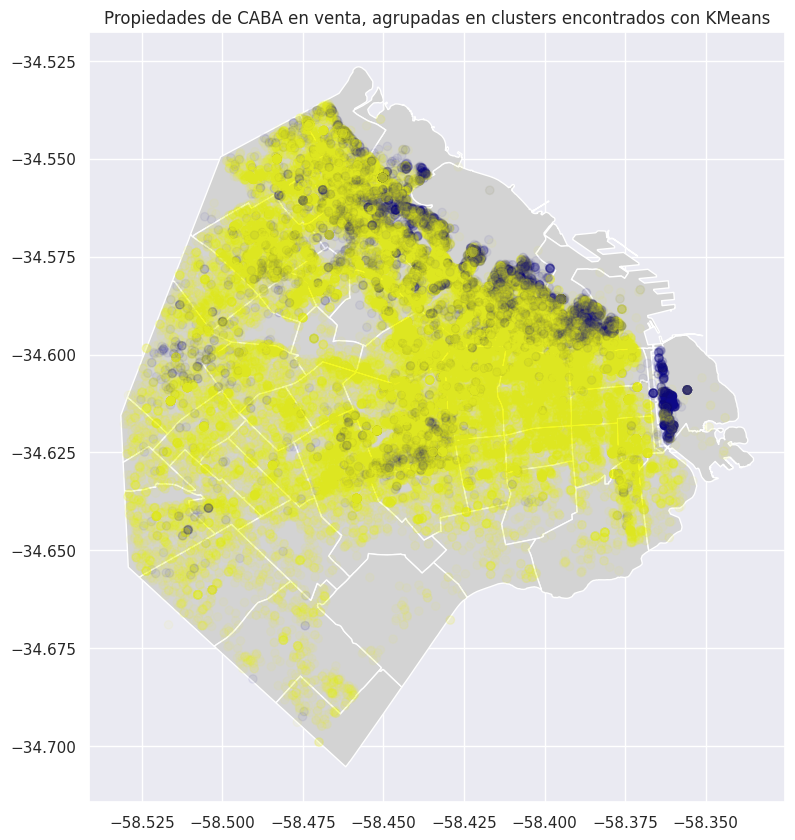

In [ ]:
def show_map(df, column_to_plot, title='', show_legend=False):
  crs = 'EPSG:4326'
  geometry = [Point(xy) for xy in zip(df['longitud'], df['latitud'])]
  geo_df = gpd.GeoDataFrame(df,
                            crs = crs,
                            geometry = geometry)

  fig, ax = plt.subplots(figsize = (10,10))
  caba_map.plot(ax=ax, color='lightgrey')

  if show_legend:
    geo_ax = geo_df.plot(column=column_to_plot, ax=ax, alpha=.05, cmap=COLORES_GRUPOS, legend=True, categorical=True)
    legend = geo_ax.get_legend()
    for handle in legend.legend_handles:
      handle.set_alpha(1)
  else:
    geo_df.plot(column=column_to_plot, ax=ax, alpha=.05, cmap=COLORES_GRUPOS)

  ax.set_title(title)

clusters = KMeans(2, random_state=0, n_init='auto').fit_predict(df[['property_rooms', 'property_surface_total', 'property_price']])
clustered_df = df.assign(cluster=clusters)

show_map(
  clustered_df,
  column_to_plot='cluster',
  title='Propiedades de CABA en venta, agrupadas en clusters encontrados con KMeans'
)

En el mapa, se ve que el grupo de anuncios de propiedades con menores precios
está repartido por toda la ciudad, mientras que el otro se encuentra bastante concentrado en 5 barrios: Puerto Madero, Retiro, Recoleta, Palermo y Belgrano. Esto ya lo habíamos adelantado cuando se realizó un análisis de los barrios de cada cluster.

Otro dato no menor es que hay grandes zonas de CABA con una muy baja densidad de anuncios, como en Villa Ligano, Villa Soldati y Villa Riachuelo, y una pequeña zona en Agronomía, La Paternal y Chacarita.

### Con tres grupos

Si aplicamos KMeans con 3 clusters, esa mayor cantidad de clusters nos va a permitir, una vez graficados los anuncios sobre el mapa, hacer observaciones un poco más precisas.

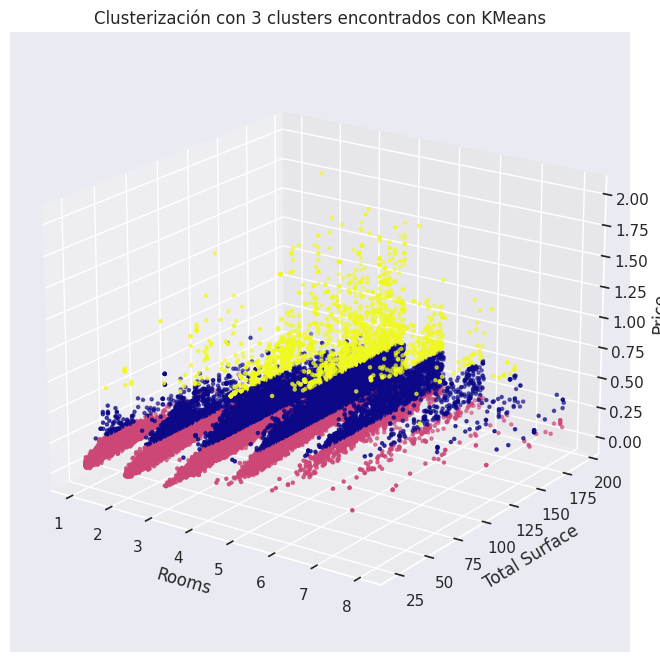

In [ ]:
clusters = kmean_scatter_plot(df, 3, "Clusterización con 3 clusters encontrados con KMeans", elev=20, axim=-55, roll=0)
clustered_df = df.assign(cluster=clusters)

In [ ]:
first_cluster = clustered_df[clustered_df['cluster'] == 0]
second_cluster = clustered_df[clustered_df['cluster'] == 1]
third_cluster = clustered_df[clustered_df['cluster'] == 2]

In [ ]:
first_cluster.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  17798.000000  17798.000000    17798.000000       17798.000000   
mean     -34.587207    -58.435430        3.580852           2.507922   
std        0.023652      0.035579        0.890951           0.797408   
min      -34.694322    -58.529554        1.000000           1.000000   
25%      -34.599875    -58.459426        3.000000           2.000000   
50%      -34.586355    -58.437446        4.000000           3.000000   
75%      -34.569374    -58.408862        4.000000           3.000000   
max      -34.536385    -58.344378        8.000000           7.000000   

       property_surface_total  property_surface_covered  property_price  \
count            17798.000000              17798.000000    17798.000000   
mean               112.541513                 97.206730   302528.087987   
std                 33.683978                 29.846803    75720.606539   
min                 31.000000                 28.000000   211220.000000   
25%                 86.000000                 74.000000   240000.000000   
50%                109.000000                 93.000000   280000.000000   
75%                136.000000                115.000000   350000.000000   
max                194.000000                194.000000   503054.000000   

       cluster  
count  17798.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0

In [ ]:
second_cluster.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  63505.000000  63505.000000    63505.000000       63505.000000   
mean     -34.598615    -58.440791        2.314274           1.516621   
std        0.026550      0.037613        0.961741           0.704012   
min      -34.698989    -58.530391        1.000000           1.000000   
25%      -34.618074    -58.468665        2.000000           1.000000   
50%      -34.599391    -58.440478        2.000000           1.000000   
75%      -34.579426    -58.411999        3.000000           2.000000   
max      -34.535964    -58.343239        8.000000           7.000000   

       property_surface_total  property_surface_covered  property_price  \
count            63505.000000              63505.000000    63505.000000   
mean                60.078227                 51.524681   119538.522305   
std                 26.199663                 20.230304    41772.785380   
min                 23.000000                 23.000000     5000.000000   
25%                 41.000000                 37.000000    85000.000000   
50%                 54.000000                 47.000000   115000.000000   
75%                 72.000000                 61.000000   150000.000000   
max                194.000000                194.000000   211000.000000   

       cluster  
count  63505.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

In [ ]:
third_cluster.describe().apply(lambda s: s.apply('{0:.5f}'.format))

latitud    longitud property_rooms property_bedrooms  \
count  2419.00000  2419.00000     2419.00000        2419.00000   
mean    -34.58341   -58.41220        3.76064           2.62712   
std       0.02074     0.03512        0.84449           0.71486   
min     -34.64024   -58.51876        1.00000           1.00000   
25%     -34.59948   -58.44120        3.00000           2.00000   
50%     -34.58029   -58.41379        4.00000           3.00000   
75%     -34.56777   -58.38429        4.00000           3.00000   
max     -34.53830   -58.35569        7.00000           6.00000   

      property_surface_total property_surface_covered property_price  \
count             2419.00000               2419.00000     2419.00000   
mean               148.94470                136.35228   705422.92807   
std                 30.44945                 30.91247   207564.46838   
min                 40.00000                 40.00000   505000.00000   
25%                127.52064                114.00000   560000.00000   
50%                152.00000                138.00000   630000.00000   
75%                175.00000                160.00000   780000.00000   
max                194.00000                194.00000  2000000.00000   

          cluster  
count  2419.00000  
mean      2.00000  
std       0.00000  
min       2.00000  
25%       2.00000  
50%       2.00000  
75%       2.00000  
max       2.00000

Con tres grupos, parecería suceder el mismo fenómeno anterior: los grupos se forman, principalmente, en función del precio de los anuncios.

- Cluster 0 -> Precios de 211220 a 503054
- Cluster 1 -> Precios de 119538 a 211000
- Cluster 2 -> Precios de 505000 a 2000000

Sin embargo, es destacable que el grupo más numeroso es el de precios intermedios, que agrupa 63.5k propiedades. Luego le seguirían el cluster de precios bajos, con 17k propiedades; y el más pequeño es el de precios altos, con 2.4k propiedades.

Respecto de las demás columnas, los promedios mantienen la misma relación que cuando se usaron dos clusters. A mayor precio, más espaciosas son las propiedades en promedio.

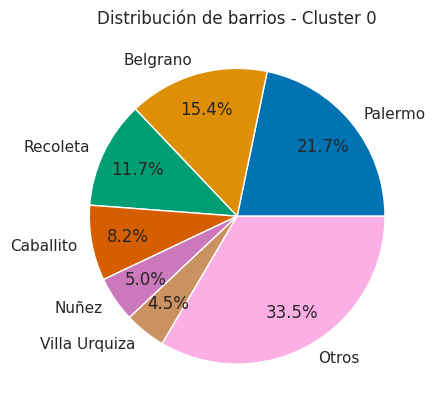

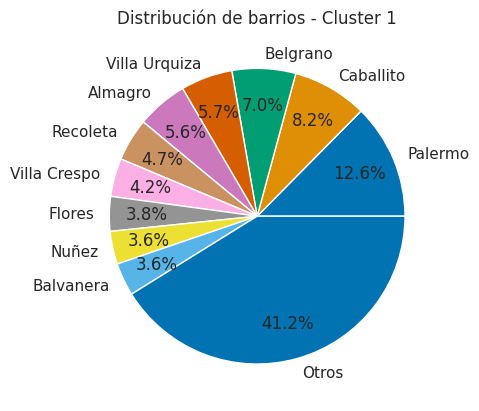

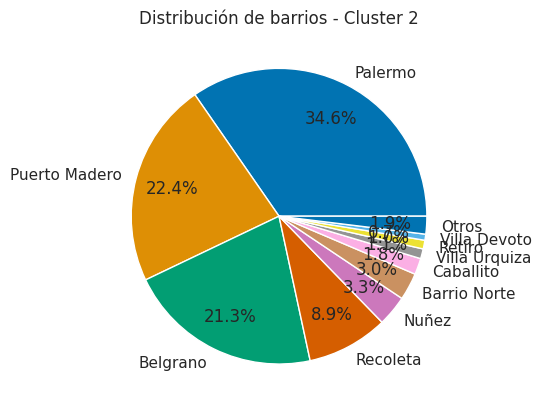

In [ ]:
plt.figure(0)
distribucion_barrios(first_cluster, 6, "Distribución de barrios - Cluster 0")
plt.figure(1)
distribucion_barrios(second_cluster, 10, "Distribución de barrios - Cluster 1")
plt.figure(2)
distribucion_barrios(third_cluster, 10, "Distribución de barrios - Cluster 2")
plt.show()

Respecto de la distribución de los barrios, en el cluster más pequeño hay una mucho mayor presencia de los barrios de Palermo, Puerto Madero y Belgrano que en los otros dos, representando un 78.3% de todos los anuncios. Se puede ver como en los demás clusters disminuye la presencia de los tres entre menores son los precios de las propiedades agrupadas.

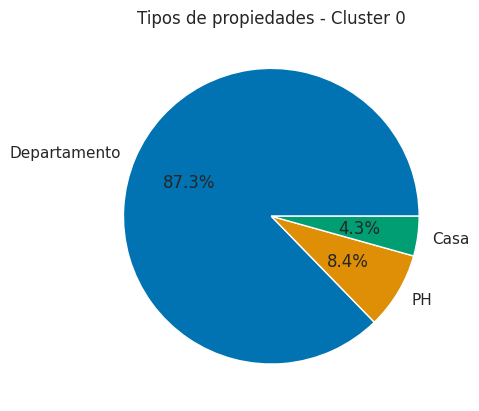

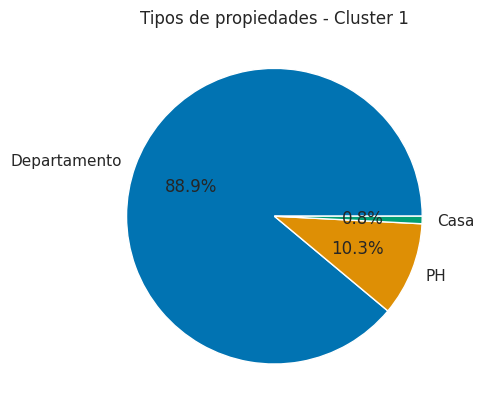

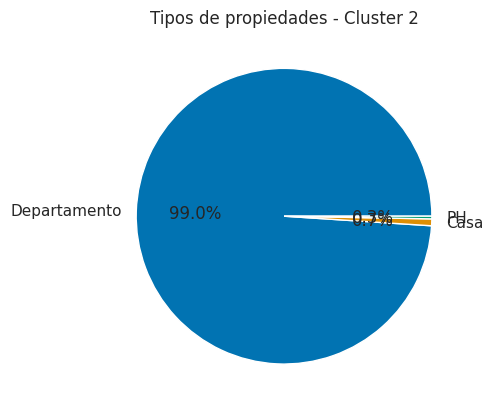

In [ ]:
plt.figure(0)
distribucion_property_type(first_cluster, "Tipos de propiedades - Cluster 0")
plt.figure(1)
distribucion_property_type(second_cluster, "Tipos de propiedades - Cluster 1")
plt.figure(2)
distribucion_property_type(third_cluster, "Tipos de propiedades - Cluster 2")
plt.show()

La distribución de tipos de propiedades es muy similar a la vista en los dos clusters que usamos para agrupar anteriormente. Sin embargo, en el cluster 2, los departamentos representan un 99% de los datos, haciendo que la presencia de casas y PHs sea muy reducidad.

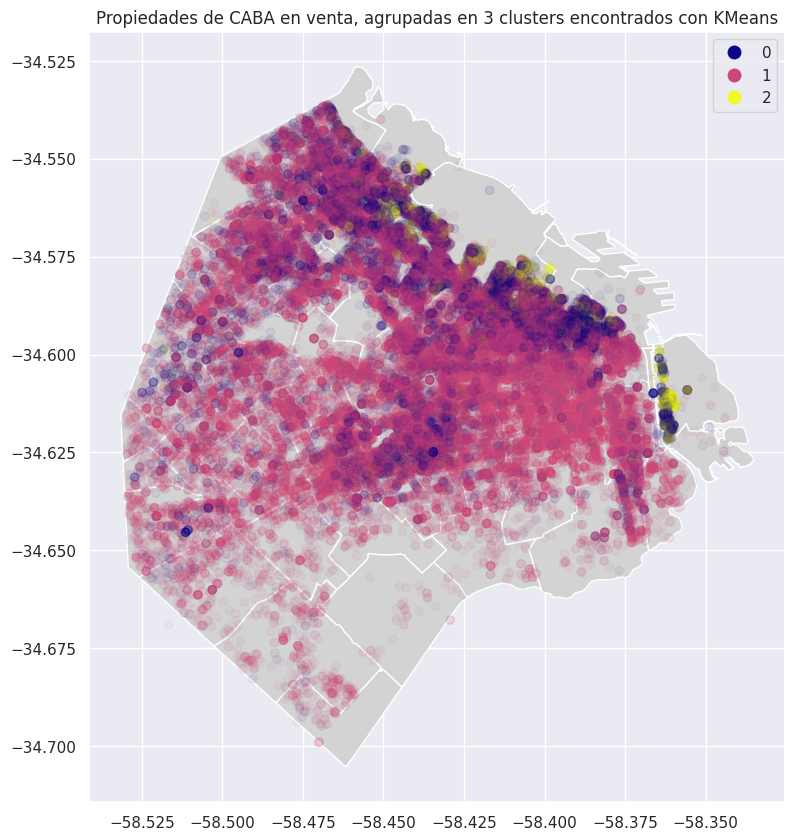

In [ ]:
show_map(
  clustered_df,
  column_to_plot='cluster',
  title='Propiedades de CABA en venta, agrupadas en 3 clusters encontrados con KMeans',
  show_legend=True
)

Como ahora disponemos de tres grupos de precios, podemos distinguir zonas en donde los anuncios tienen un precio intermedio, ni muy alto ni muy bajo. Entre ellas, se destacan Caballito y Almagro.

También, se puede ver que en las zonas con los precios más altos, hay mayor cantidad de anuncios con precios intermedios que en el resto de los barrios.

# Clasificación

## Construcción del target

In [134]:
TIPOS_PRECIO = ['bajo', 'medio', 'alto']

In [135]:
df['precio_m2'] = df['property_price'] / df['property_surface_total']

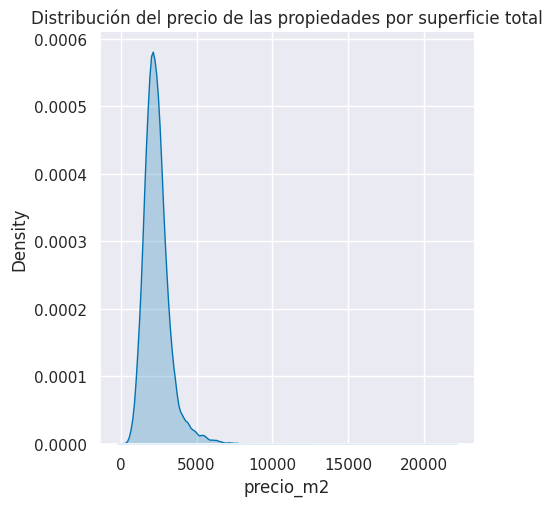

In [136]:
sns.displot(data=df['precio_m2'], kind='kde', fill=True).set(title="Distribución del precio de las propiedades por superficie total")

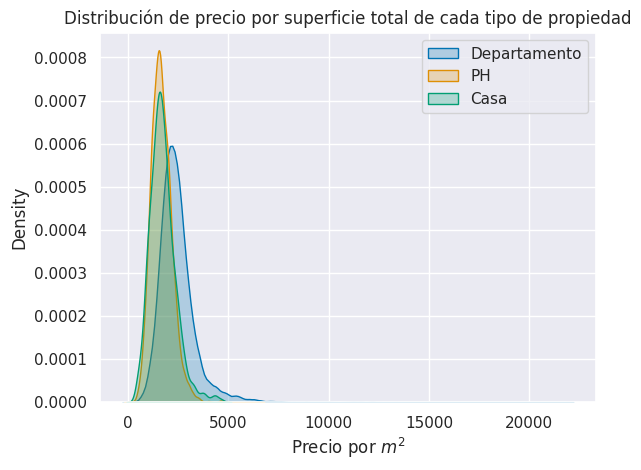

In [137]:
sns.kdeplot(data=df[df['property_type'] == 'Departamento']['precio_m2'], fill=True, label="Departamento").set(title="Distribución de precio por superficie total de cada tipo de propiedad")
sns.kdeplot(data=df[df['property_type'] == 'PH']['precio_m2'], fill=True, label='PH')
sns.kdeplot(data=df[df['property_type'] == 'Casa']['precio_m2'], fill=True, label='Casa')

plt.xlabel('Precio por $m^2$')
plt.legend()

In [138]:
precios_bins_iguales = pd.qcut(df['precio_m2'], q=3, labels=TIPOS_PRECIO)
precios_bins_q1_y_q3 = pd.qcut(df['precio_m2'], q=[0, 0.25, 0.75, 1], labels=TIPOS_PRECIO)

In [139]:
df_departamentos = df[df['property_type'] == 'Departamento']
df_phs = df[df['property_type'] == 'PH']
df_casas = df[df['property_type'] == 'Casa']

precios_bins_departamentos = pd.qcut(df_departamentos['precio_m2'], q=[0, 0.25, 0.75, 1], labels=TIPOS_PRECIO)
precios_bins_phs = pd.qcut(df_phs['precio_m2'], q=[0, 0.25, 0.75, 1], labels=TIPOS_PRECIO)
precios_bins_casas = pd.qcut(df_casas['precio_m2'], q=[0, 0.25, 0.75, 1], labels=TIPOS_PRECIO)

In [140]:
precios_bins_iguales.value_counts()

precio_m2
bajo     27977
alto     27878
medio    27867
Name: count, dtype: int64

In [141]:
precios_bins_q1_y_q3.value_counts()

precio_m2
medio    41854
bajo     20937
alto     20931
Name: count, dtype: int64

[Text(0.5, 1.0, 'Distribución del tipo de precio con intervalos iguales')]

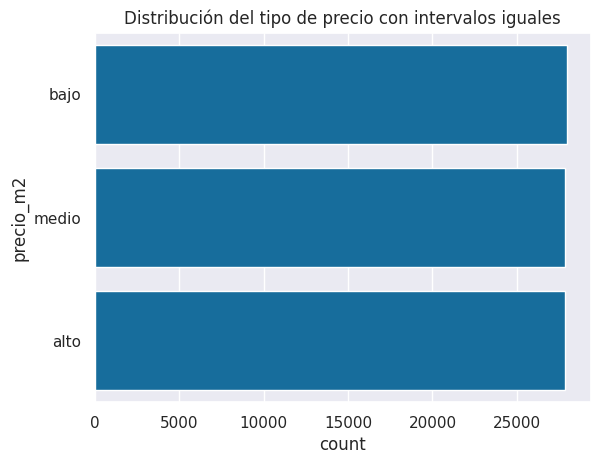

In [142]:
sns.countplot(data=precios_bins_iguales).set(title="Distribución del tipo de precio con intervalos iguales")

[Text(0.5, 1.0, 'Distribución del tipo de precio con cuartiles')]

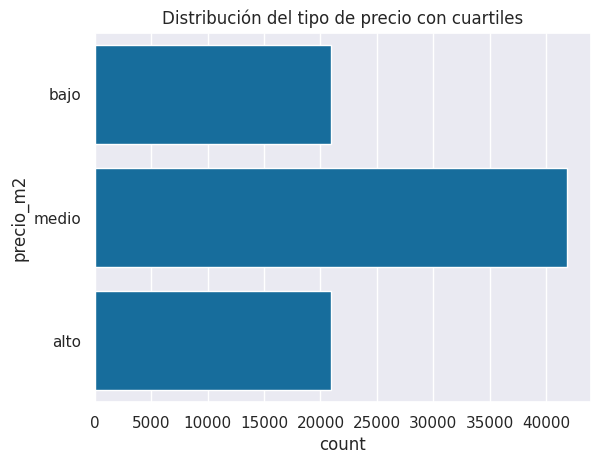

In [143]:
sns.countplot(data=precios_bins_q1_y_q3).set(title="Distribución del tipo de precio con cuartiles")

[Text(0.5, 1.0, 'Distribución del tipo de precio con cuartiles')]

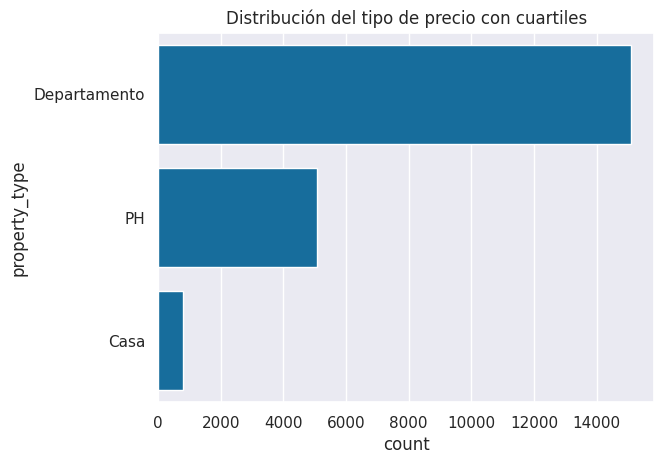

In [144]:
sns.countplot(data=df[precios_bins_q1_y_q3 == 'bajo']['property_type']).set(title="Distribución del tipo de precio con cuartiles")

[Text(0.5, 1.0, 'Distribución del tipo de precio con cuartiles')]

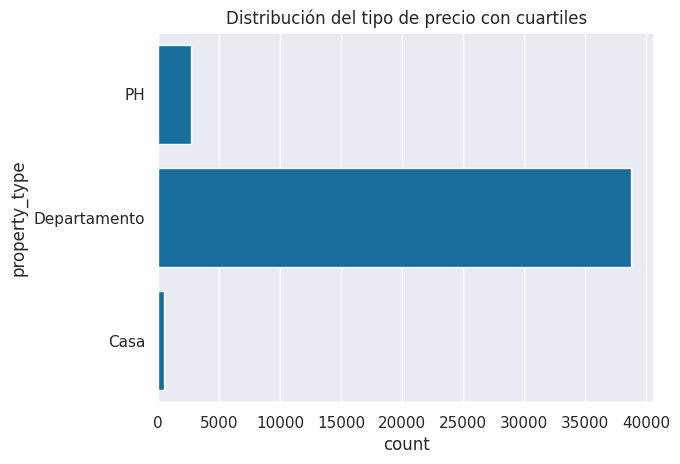

In [145]:
sns.countplot(data=df[precios_bins_q1_y_q3 == 'medio']['property_type']).set(title="Distribución del tipo de precio con cuartiles")

[Text(0.5, 1.0, 'Distribución del tipo de precio con cuartiles')]

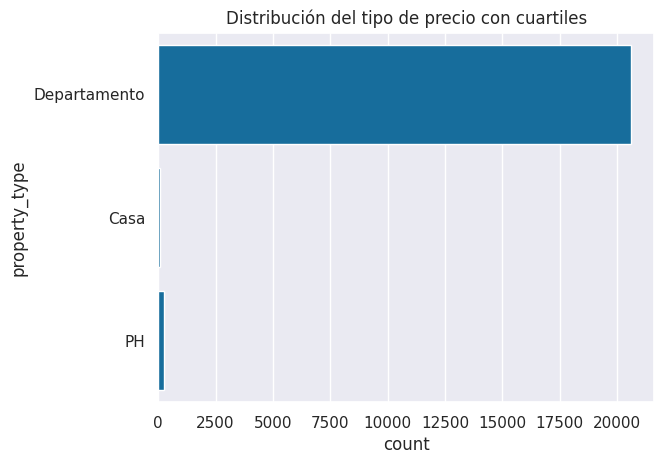

In [146]:
sns.countplot(data=df[precios_bins_q1_y_q3 == 'alto']['property_type']).set(title="Distribución del tipo de precio con cuartiles")

[Text(0.5, 1.0, 'Distribución del tipo de precio de departamentos')]

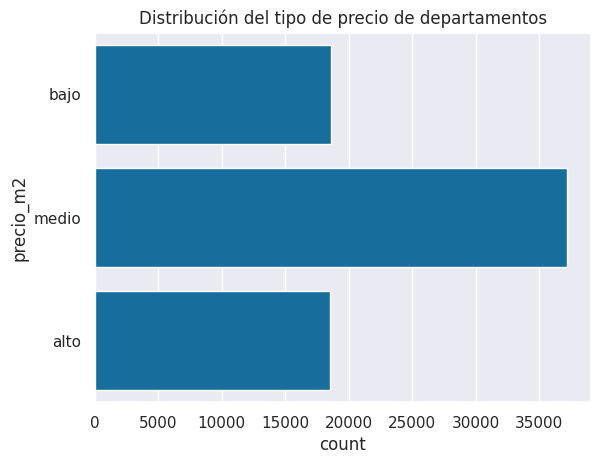

In [147]:
sns.countplot(data=precios_bins_departamentos).set(title="Distribución del tipo de precio de departamentos")

[Text(0.5, 1.0, 'Distribución del tipo de precio de PHs')]

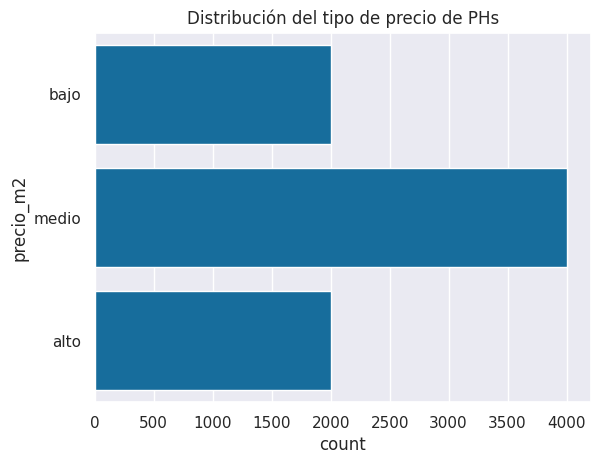

In [148]:
sns.countplot(data=precios_bins_phs).set(title="Distribución del tipo de precio de PHs")

[Text(0.5, 1.0, 'Distribución del tipo de precio de casas')]

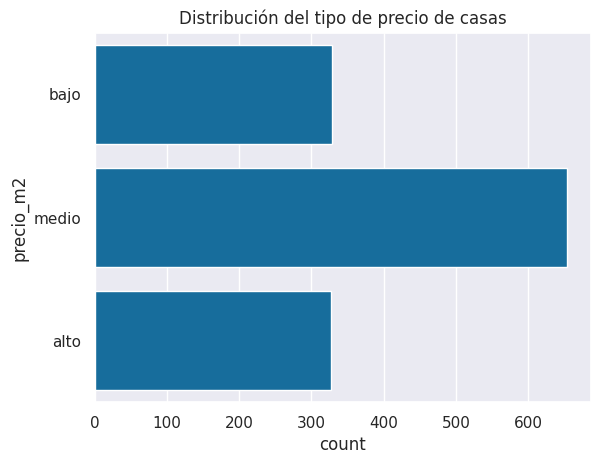

In [149]:
sns.countplot(data=precios_bins_casas).set(title="Distribución del tipo de precio de casas")

La forma que seleccionamos para definir los límites de cada categoría es la tercera, en donde tenemos en cuenta el tipo de las propiedades. Como se puede ver en el siguiente gráfico, la cantidad de departamentos es muy superior a la cantidad de casas y PHs. Si no tenemos en cuenta el tipo de propiedad a la hora de categorizar, los departamentos tendrían mucho más peso sobre ella que las casas y los PHs.

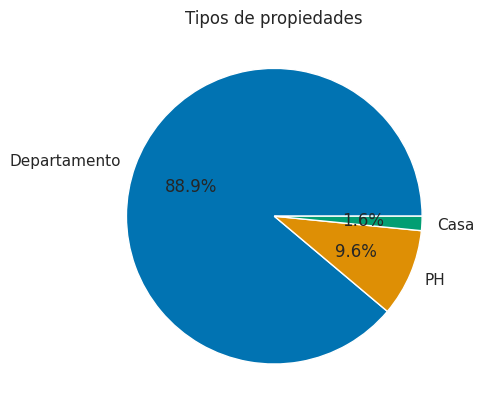

In [150]:
distribucion_property_type(df, "Tipos de propiedades")

In [151]:
df.loc[df['property_type'] == 'Casa', 'tipo_precio'] = precios_bins_casas
df.loc[df['property_type'] == 'PH', 'tipo_precio'] = precios_bins_phs
df.loc[df['property_type'] == 'Departamento', 'tipo_precio'] = precios_bins_departamentos

La forma que seleccionamos guarda algunas similitudes con la divisón de tres grupos obtenida utilizando KMeans. La más importante es que con ambos métodos nos quedaron grupos caracterizados principalmente por contener un rango de precios bien marcado. Otra es que el grupo que contiene los precios intermedios es el más numeroso para ambos métodos. Sin embargo, cuando usamos KMeans, los otros dos clusters eran mucho más pequeños, y no llegaban a contener el 25% de los datos.

Por otra parte, una diferencia muy clara es que cuando hicimos KMeans, la distribución de los tipos de propiedades era distinta en cada cluster. Incluso, en el cluster de precios más altos, había un 99% de departamentos. Usando este otro método, nos aseguramos que la distribución de tipos de propiedades de cada grupo sea exactamente la misma.

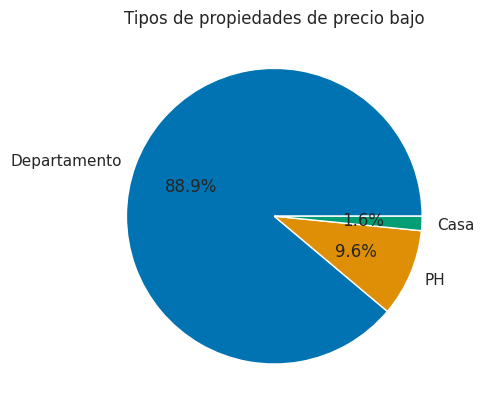

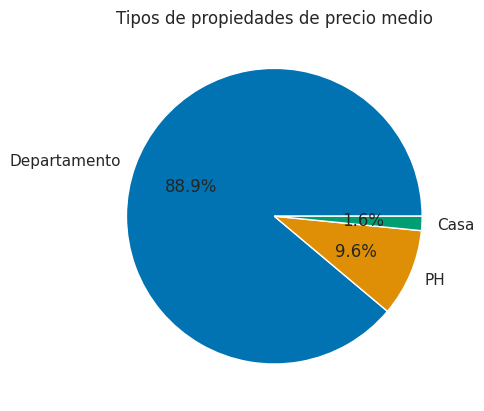

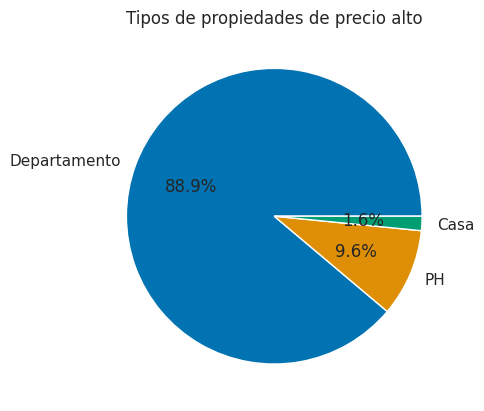

In [152]:
plt.figure(0)
distribucion_property_type(df[df['tipo_precio'] == 'bajo'], "Tipos de propiedades de precio bajo")
plt.figure(1)
distribucion_property_type(df[df['tipo_precio'] == 'medio'], "Tipos de propiedades de precio medio")
plt.figure(2)
distribucion_property_type(df[df['tipo_precio'] == 'alto'], "Tipos de propiedades de precio alto")
plt.show()

In [153]:
show_map(
  df,
  column_to_plot='tipo_precio',
  title='Propiedades en venta por tipo de precio',
  show_legend=True
)

NameError: name 'show_map' is not defined

## Entrenamiento y predicción

In [157]:
df.to_csv('propiedades.csv')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('tipo_precio', axis='columns'), df['tipo_precio'], test_size=0.20, random_state=137)

DF
https://drive.google.com/file/d/1GhsJwy29gS2y_HibaDeChkx-ozSc2Qc3/view?usp=drive_link